# Часть 1

## Импорт библиотек

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

import pickle
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier

## Загрузка датасетов

In [5]:
ga_sessions = pd.read_csv('data/ga_sessions.csv', low_memory=False)
ga_hits = pd.read_csv('data/ga_hits.csv', low_memory=False)

In [6]:
ga_sessions.shape

(1860042, 18)

In [7]:
ga_hits.shape

(15726470, 11)

In [8]:
ga_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [9]:
ga_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


## Выделение столбца с ЦД из таблицы ga_hits

In [10]:
#выделяем в отдельную таблицу строки с целевыми действями
ga_hits_target = ga_hits[ga_hits.event_action.isin(['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click'])]

In [11]:
# проверям значения столбца event_action
ga_hits_target.event_action.unique()

array(['sub_submit_success', 'sub_car_claim_click',
       'sub_open_dialog_click', 'sub_car_claim_submit_click',
       'sub_car_request_submit_click', 'sub_call_number_click',
       'sub_callback_submit_click', 'sub_custom_question_submit_click'],
      dtype=object)

In [12]:
# отбрасываем все столбцы, кроме session_id и event_action
ga_hits_target = ga_hits_target[['session_id', 'event_action']]
ga_hits_target

,session_id,event_action
4016,2744563715298057088.1640258436.1640258436,sub_submit_success
4045,3087297479839089634.1640268774.1640268774,sub_submit_success
4046,3156966333326004302.1640206419.1640206800,sub_submit_success
4047,3750243879753098158.1640272208.1640272208,sub_submit_success
4048,7518333712042258254.1640258901.1640258901,sub_submit_success
...,...,...
15725025,1277864870843199549.1636773954.1636773954,sub_car_claim_submit_click
15725133,965861352491898977.1636751459.1636751459,sub_submit_success
15725134,4727705172767122620.1636818847.1636818847,sub_submit_success
15725135,4727705172767122620.1636818847.1636818847,sub_open_dialog_click


In [13]:
# Добавялем столбец target, заполненный 1, так как сейчас мы имеем дело со всеми сессиями, где целевое действие было совершено
ga_hits_target['target'] = 1
ga_hits_target

,session_id,event_action,target
4016,2744563715298057088.1640258436.1640258436,sub_submit_success,1
4045,3087297479839089634.1640268774.1640268774,sub_submit_success,1
4046,3156966333326004302.1640206419.1640206800,sub_submit_success,1
4047,3750243879753098158.1640272208.1640272208,sub_submit_success,1
4048,7518333712042258254.1640258901.1640258901,sub_submit_success,1
...,...,...,...
15725025,1277864870843199549.1636773954.1636773954,sub_car_claim_submit_click,1
15725133,965861352491898977.1636751459.1636751459,sub_submit_success,1
15725134,4727705172767122620.1636818847.1636818847,sub_submit_success,1
15725135,4727705172767122620.1636818847.1636818847,sub_open_dialog_click,1


In [14]:
#Удаляем столбец event_action. Он больше не нужен
ga_hits_target = ga_hits_target.drop(['event_action'], axis = 1)
ga_hits_target

,session_id,target
4016,2744563715298057088.1640258436.1640258436,1
4045,3087297479839089634.1640268774.1640268774,1
4046,3156966333326004302.1640206419.1640206800,1
4047,3750243879753098158.1640272208.1640272208,1
4048,7518333712042258254.1640258901.1640258901,1
...,...,...
15725025,1277864870843199549.1636773954.1636773954,1
15725133,965861352491898977.1636751459.1636751459,1
15725134,4727705172767122620.1636818847.1636818847,1
15725135,4727705172767122620.1636818847.1636818847,1


In [15]:
#Проверим размерность датасета
ga_hits_target.shape

(104908, 2)

In [16]:
# В соответствии с условием задачи, если целевых действий больше одного, считаем как одно, поэтому проверяем таблицу на дубли
ga_hits_target[ga_hits_target.duplicated()].sum()

session_id    1929569077899335811.1640273714.164027371431569...
target                                                    54148
dtype: object

In [17]:
# Удаляем продублированные строки
ga_hits_target = ga_hits_target.drop_duplicates()
ga_hits_target[ga_hits_target.duplicated()].sum()

session_id    0
target        0
dtype: object

In [18]:
ga_hits_target.shape

(50760, 2)

## Объединение двух таблиц

In [19]:
print(ga_hits_target.shape)
print(ga_sessions.shape)

(50760, 2)
(1860042, 18)


In [20]:
df_full = ga_sessions.merge(ga_hits_target, on='session_id', how='left')
df_full.shape

(1860042, 19)

In [21]:
df_full.target = df_full.target.fillna(0)

In [22]:
df_full.target.value_counts()

target
0.0    1809728
1.0      50314
Name: count, dtype: int64

In [23]:
#df_full.to_csv('data/df_session_with_target.csv', index = False)

In [24]:
df_full.columns.tolist()

['session_id',
 'client_id',
 'visit_date',
 'visit_time',
 'visit_number',
 'utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_model',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city',
 'target']

In [25]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              int64  
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_model              object 
 14  device_screen_resolution  object 
 15  device_browser            object 
 16  geo_country               object 
 17  geo_city                  object 
 18  target                    float64
dtypes: float64(1), int64(1), object(17)
memory usage: 269.6+ MB


## Data Preparation

### Проверка на дубликаты

In [26]:
df_full[df_full.duplicated()].sum()

session_id                    0
client_id                     0
visit_date                    0
visit_time                    0
visit_number                  0
utm_source                    0
utm_medium                    0
utm_campaign                  0
utm_adcontent                 0
utm_keyword                   0
device_category               0
device_os                     0
device_brand                  0
device_model                  0
device_screen_resolution      0
device_browser                0
geo_country                   0
geo_city                      0
target                      0.0
dtype: object

### Анализ пропусков

#### Общий анализ

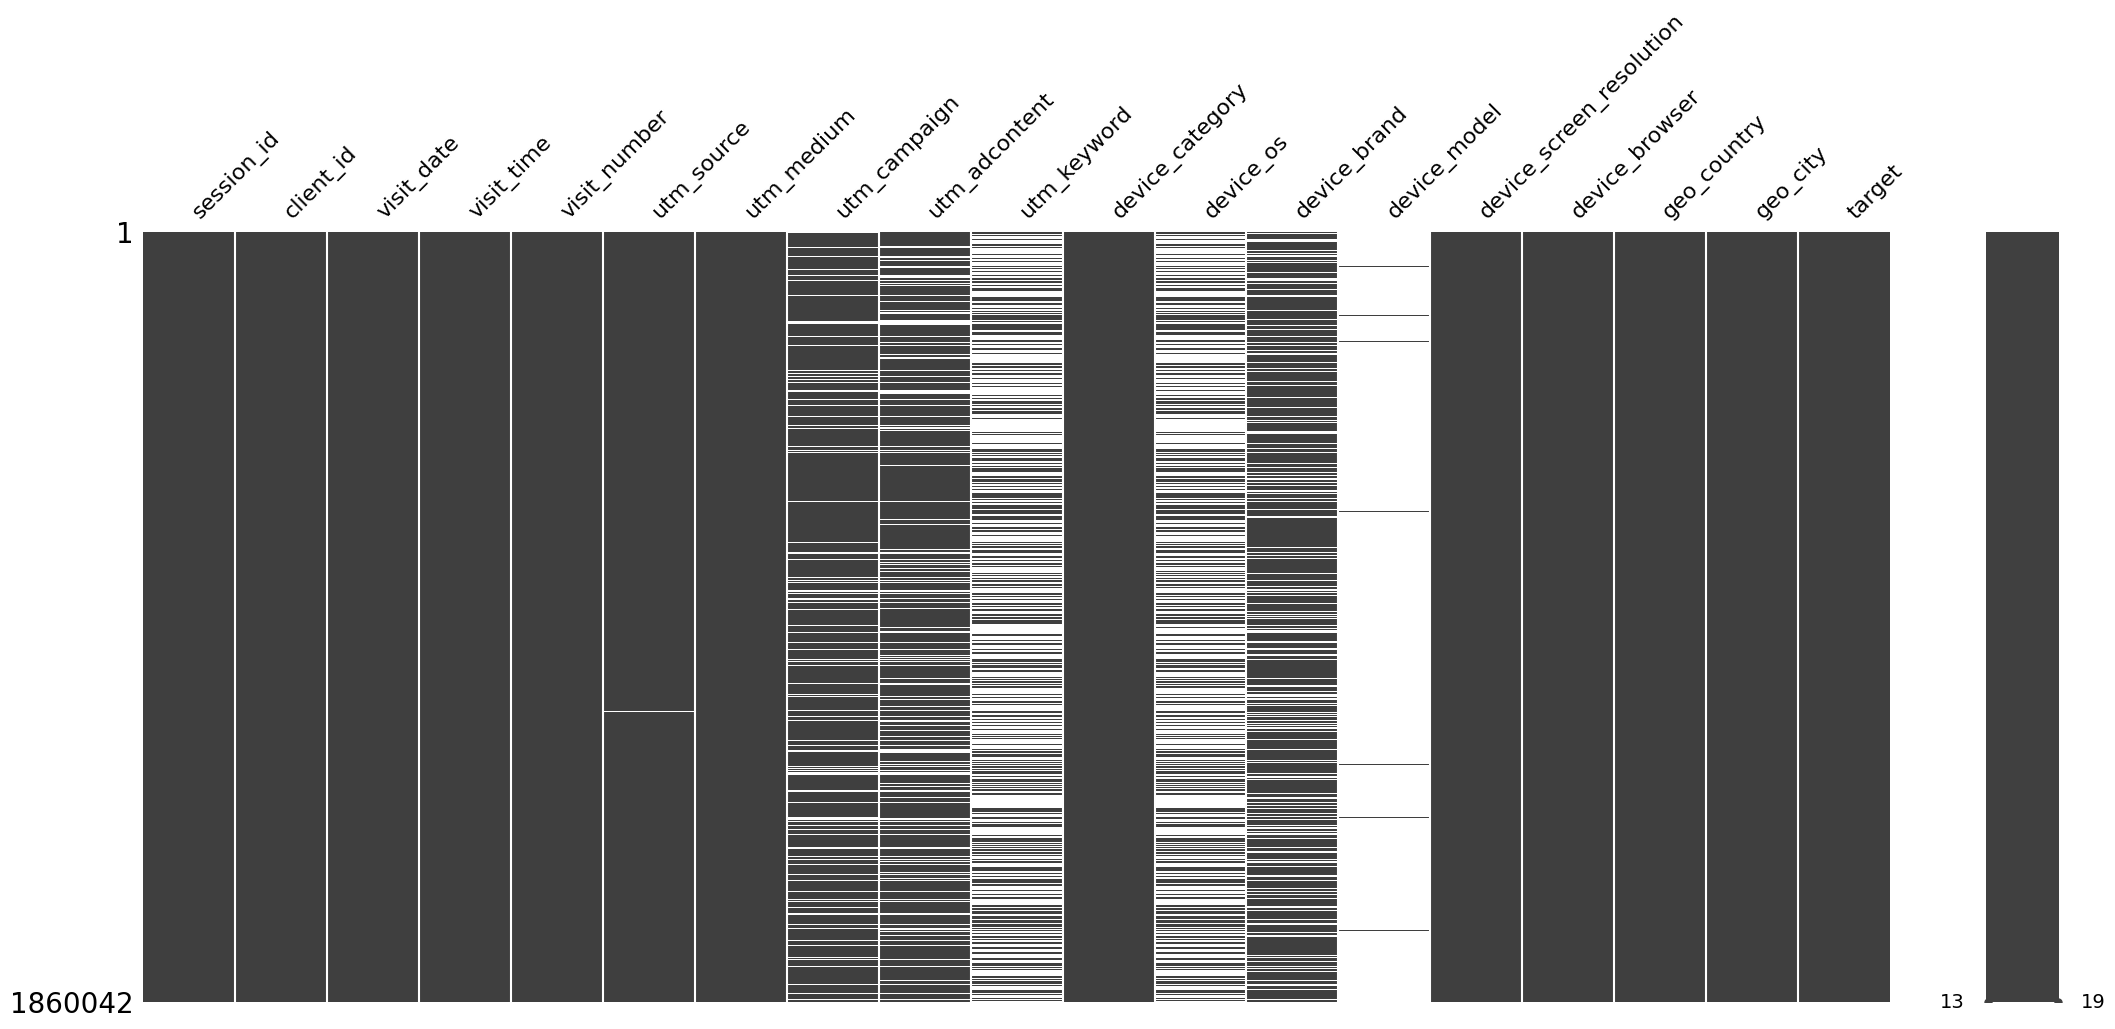

In [27]:
msno.matrix(df_full);

In [28]:
def print_usefull_rows_info_full(df):
    print('Количество полностью заполненных объектов в выборке: ', len(df.dropna()))
    print('Процент полностью заполненных объектов в выборке: ', round(len(df.dropna()) / len(df) * 100, 2))
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending = False)
    print(f'Процент пропусков по столбцам: \n{missing_values}')

In [29]:
print_usefull_rows_info_full(df_full)

Количество полностью заполненных объектов в выборке:  14940
Процент полностью заполненных объектов в выборке:  0.8
Процент пропусков по столбцам: 
device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
target                       0.000000
dtype: float64


#### Обработка пропусков в столбце device_model

In [30]:
def print_useful_rows_info_column(df, column):
    print(f'Процент пропущенных значений в {column}: {round(df[column].isna().sum() / len(df) * 100, 2)}')
    print(f'Количество пропущенных значений в {column}: {df[column].isna().sum()}')

In [31]:
print_useful_rows_info_column(df_full, 'device_model')

Процент пропущенных значений в device_model: 99.12
Количество пропущенных значений в device_model: 1843704


In [32]:
# Решаю удалить данный столбец
df_clean = df_full.copy()
df_clean = df_clean.drop(['device_model'], axis = 1)

In [33]:
print_usefull_rows_info_full(df_clean)

Количество полностью заполненных объектов в выборке:  578427
Процент полностью заполненных объектов в выборке:  31.1
Процент пропусков по столбцам: 
utm_keyword                 58.174009
device_os                   57.533002
device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
target                       0.000000
dtype: float64


#### Обработка пропусков в столбце utm_keyword

In [34]:
print_useful_rows_info_column(df_clean, 'utm_keyword')

Процент пропущенных значений в utm_keyword: 58.17
Количество пропущенных значений в utm_keyword: 1082061


In [35]:
# В столбце utm_keyword пропущено почти 60 процентов всех данных. Считаю, что как-либо искусственно его заполнять не стоит. Поэтому этот столбец удаляю.
df_clean = df_clean.drop(['utm_keyword'], axis = 1)

In [36]:
print_usefull_rows_info_full(df_clean)

Количество полностью заполненных объектов в выборке:  578853
Процент полностью заполненных объектов в выборке:  31.12
Процент пропусков по столбцам: 
device_os                   57.533002
device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
target                       0.000000
dtype: float64


#### Обработка пропусков в столбцax device_brand и device_os

In [37]:
print_useful_rows_info_column(df_clean, 'device_brand')

Процент пропущенных значений в device_brand: 19.74
Количество пропущенных значений в device_brand: 367178


In [38]:
print_useful_rows_info_column(df_clean, 'device_os')

Процент пропущенных значений в device_os: 57.53
Количество пропущенных значений в device_os: 1070138


In [39]:
df_clean['device_os'].value_counts(dropna=False)

device_os
NaN              1070138
Android           464054
iOS               207104
Windows            88307
Macintosh          24824
Linux               5120
(not set)            364
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: count, dtype: int64

In [40]:
df_clean['device_brand'].value_counts(dropna=False)

device_brand
Apple       551088
NaN         367178
Samsung     332194
Xiaomi      288367
Huawei      185853
             ...  
Vodafone         1
Wexler           1
KingSing         1
Star             1
Opera            1
Name: count, Length: 206, dtype: int64

In [41]:
df_clean[(df_clean["device_os"].isna()) & (df_clean["device_brand"].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
63,9055657327967035032.1629707931.1629707931,2108434524.1629707928,2021-08-23,11:00:00,1,nSReTmyFtbSjlPrTKoaX,banner,BVKxkCOHKUOvkpbrLMgZ,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,1920x1080,YaBrowser,Russia,Moscow,0.0
64,905565977351442956.1622561294.1622561294,210843509.1622561292,2021-06-01,18:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,1920x1080,Chrome,Russia,Moscow,0.0
73,9055788191321875859.1626006934.1626006934,2108464993.1626006931,2021-07-11,15:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,1280x720,Chrome,Russia,Moscow,0.0
74,9055788191321875859.1627377569.1627377569,2108464993.1626006931,2021-07-27,12:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,nSReTmyFtbSjlPrTKoaX,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,1920x1080,Chrome,Russia,Moscow,0.0
78,9055794766915104430.1624305327.1624305327,2108466524.1624305326,2021-06-21,22:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,NaN,NaN,834x1112,Safari,Russia,Domodedovo,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860020,9055329372850890545.1629287172.1629287172,2108358166.1626351409,2021-08-18,14:00:00,3,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,NaN,NaN,1920x1080,YaBrowser,Russia,Moscow,0.0
1860021,9055343778173115129.1628265209.1628265209,2108361520.1628265209,2021-08-06,18:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,1920x1080,Firefox,Russia,Moscow,0.0
1860022,9055345397369530035.1622009529.1622009529,2108361897.1622009523,2021-05-26,09:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,1536x864,Firefox,Russia,(not set),0.0
1860027,9055363711117247375.1629176721.1629176721,2108366161.1629176719,2021-08-17,08:00:00,1,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,desktop,NaN,NaN,1920x1080,Chrome,Russia,(not set),0.0


In [42]:
#В объектах, где неизвестно ни device_os, ни device_brand, указываем значение other
df_clean.loc[(df_clean["device_os"].isna()) & (df_clean["device_brand"].isna()), ['device_os', 'device_brand']] = 'other'

In [43]:
df_clean['device_os'].value_counts(dropna=False)

device_os
NaN              821638
Android          464054
other            248500
iOS              207104
Windows           88307
Macintosh         24824
Linux              5120
(not set)           364
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

In [44]:
df_clean['device_brand'].value_counts(dropna=False)

device_brand
Apple       551088
Samsung     332194
Xiaomi      288367
other       248500
Huawei      185853
             ...  
Vodafone         1
Wexler           1
KingSing         1
Star             1
Opera            1
Name: count, Length: 207, dtype: int64

Все верно, в обоих столбцах в 248500 объектах теперь вместо NaN - other

In [45]:
print_useful_rows_info_column(df_clean, 'device_brand')

Процент пропущенных значений в device_brand: 6.38
Количество пропущенных значений в device_brand: 118678


In [46]:
df_clean[df_clean['device_brand'].isna()].device_os.value_counts()

device_os
Windows      88307
Macintosh    24824
Linux         5120
(not set)      344
Chrome OS       83
Name: count, dtype: int64

Так как на операционной системе Macintosh работают только устройства от Apple, занесем для них значение Apple в device_brand

In [47]:
df_clean.loc[(df_clean["device_brand"].isna()) & (df_clean["device_os"] == 'Macintosh'), 'device_brand'] = 'Apple'

In [48]:
print_useful_rows_info_column(df_clean, 'device_brand')

Процент пропущенных значений в device_brand: 5.05
Количество пропущенных значений в device_brand: 93854


Под оставшимися ОС могут работать устройства разных производителей, поэтому для них укажем в столбце device_brand значение other

In [49]:
df_clean.device_brand = df_clean.device_brand.fillna('other')

In [50]:
print_useful_rows_info_column(df_clean, 'device_brand')

Процент пропущенных значений в device_brand: 0.0
Количество пропущенных значений в device_brand: 0


Пропуски в столбце device_brand обработаны. Переходим к столбцу device_os

In [51]:
print_useful_rows_info_column(df_clean, 'device_os')

Процент пропущенных значений в device_os: 44.17
Количество пропущенных значений в device_os: 821638


In [52]:
df_clean['device_os'].value_counts(dropna=False)

device_os
NaN              821638
Android          464054
other            248500
iOS              207104
Windows           88307
Macintosh         24824
Linux              5120
(not set)           364
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

In [53]:
df_clean[df_clean['device_os'].isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
5,9055447192389856083.1622453074.1622453074,2108385598.1622453075,2021-05-31,12:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Apple,375x812,Safari,Russia,Saint Petersburg,0.0
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Samsung,360x640,Chrome,Russia,Saint Petersburg,0.0
9,9055466554104774132.1624800757.1624800757,2108390106.1624800756,2021-06-27,16:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Samsung,412x915,Chrome,Russia,Moscow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860030,9055382948278467242.1631877802.1631877802,2108370640.1631877802,2021-09-17,14:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,NaN,Xiaomi,393x851,Chrome,Russia,Saint Petersburg,0.0
1860032,9055394269810294140.1629912447.1629912447,2108373276.1629912444,2021-08-25,20:00:00,1,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Samsung,360x800,Android Webview,Russia,Saint Petersburg,1.0
1860034,9055397194683347295.1630237022.1630237022,2108373957.1630237023,2021-08-29,14:00:00,1,ISrKoXQCxqqYvAZICvjs,blogger_stories,zfwIehuEfWYdYrEZgRLo,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Apple,414x896,Safari,Russia,Zheleznodorozhny,0.0
1860035,9055398929844789828.1624891784.1624891784,2108374361.1624891972,2021-06-28,17:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,vXsFkagGabkcWKlgLzSg,NaN,mobile,NaN,Samsung,320x676,Chrome,Russia,Naro-Fominsk,0.0


In [54]:
df_clean[df_clean['device_os'].isna()].device_brand.value_counts()

device_brand
Apple       343990
Samsung     166510
Xiaomi      147224
Huawei       96135
Realme        8195
             ...  
Jiake            1
Olla             1
Krip             1
KingSing         1
Maxvi            1
Name: count, Length: 180, dtype: int64

Известно, что планшеты и мобильные телефоны бренда Apple работают на ОС iOS, а стационарные компьютеры на Macintosh. Заполним такие объекты

In [55]:
df_clean.loc[(df_clean["device_os"].isna()) & (df_clean["device_brand"] == 'Apple') & (df_clean["device_category"] != 'desktop'), 'device_os'] = 'iOS'
df_clean.loc[(df_clean["device_os"].isna()) & (df_clean["device_brand"] == 'Apple') & (df_clean["device_category"] == 'desktop'), 'device_os'] = 'Macintosh'

In [56]:
#Проверяем, что больше нет объектов с пропущенными значениями device_os от производителя Apple
len(df_clean[(df_clean['device_os'].isna()) & (df_clean['device_brand'] == 'Apple')])

0

In [57]:
print_useful_rows_info_column(df_clean, 'device_os')

Процент пропущенных значений в device_os: 25.68
Количество пропущенных значений в device_os: 477648


In [58]:
df_clean[df_clean['device_os'].isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Samsung,360x640,Chrome,Russia,Saint Petersburg,0.0
9,9055466554104774132.1624800757.1624800757,2108390106.1624800756,2021-06-27,16:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Samsung,412x915,Chrome,Russia,Moscow,0.0
10,9055466554104774132.1629442326.1629442326,2108390106.1624800756,2021-08-20,09:00:00,2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Samsung,412x915,Chrome,Russia,Moscow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860024,9055349030922605117.1632752193.1632752193,2108362743.1632752189,2021-09-27,17:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,NaN,BQ,640x360,YaBrowser,Russia,Saint Petersburg,0.0
1860028,9055373598132450813.1629664766.1629664766,2108368463.1629664765,2021-08-22,23:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,NaN,Xiaomi,851x393,Chrome,Russia,Saint Petersburg,0.0
1860030,9055382948278467242.1631877802.1631877802,2108370640.1631877802,2021-09-17,14:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,NaN,Xiaomi,393x851,Chrome,Russia,Saint Petersburg,0.0
1860032,9055394269810294140.1629912447.1629912447,2108373276.1629912444,2021-08-25,20:00:00,1,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Samsung,360x800,Android Webview,Russia,Saint Petersburg,1.0


In [59]:
df_clean[df_clean['device_os'].isna()].device_brand.value_counts()

device_brand
Samsung      166510
Xiaomi       147224
Huawei        96135
Realme         8195
(not set)      7767
              ...  
Jiake             1
Olla              1
Krip              1
KingSing          1
Maxvi             1
Name: count, Length: 179, dtype: int64

Также известно, что компания Самсунг выпускает практически все свои мобильные телефоны и планшеты под ОС Andriod, а стационарные компьютеры под ОС Windows. Заполним такие пробелы.

In [60]:
df_clean.loc[(df_clean["device_os"].isna()) & (df_clean["device_brand"] == 'Samsung') & (df_clean["device_category"] != 'desktop'), 'device_os'] = 'Android'
df_clean.loc[(df_clean["device_os"].isna()) & (df_clean["device_brand"] == 'Samsung') & (df_clean["device_category"] == 'desktop'), 'device_os'] = 'Windows'

In [61]:
df_clean[df_clean['device_os'].isna()].device_brand.value_counts()

device_brand
Xiaomi       147224
Huawei        96135
Realme         8195
(not set)      7767
OPPO           6493
              ...  
Jiake             1
Olla              1
Krip              1
KingSing          1
Maxvi             1
Name: count, Length: 178, dtype: int64

In [62]:
df_clean['device_os'].value_counts()

device_os
Android          630559
iOS              551055
other            248500
Windows           88312
Macintosh         24863
Linux              5120
(not set)           364
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

Компании Xiaomi, Huawei, Realme, OPPO выпускают свои устройства под ОС Android. В целом считаю уместным все оставшиеся пропуски в столбце device_os заполнить значением Andriod.

In [63]:
df_clean.device_os = df_clean.device_os.fillna('Android')

In [64]:
print_useful_rows_info_column(df_clean, 'device_brand')

Процент пропущенных значений в device_brand: 0.0
Количество пропущенных значений в device_brand: 0


In [65]:
print_usefull_rows_info_full(df_clean)

Количество полностью заполненных объектов в выборке:  1507241
Процент полностью заполненных объектов в выборке:  81.03
Процент пропусков по столбцам: 
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
device_os                    0.000000
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_brand                 0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
target                       0.000000
dtype: float64


#### Обработка пропусков в столбце utm_adcontent

In [66]:
df_clean[df_clean['utm_adcontent'].isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
14,9055469620715506713.1636559415.1636559415,2108390820.1628883993,2021-11-10,18:50:15,4,SzZERoLMmrEUEhDaYcyN,cpc,NaN,NaN,mobile,Android,Samsung,412x869,Android Webview,Russia,Saint Petersburg,0.0
27,9055504865227535872.1639282176.1639282176,2108399026.1639282176,2021-12-12,07:09:36,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,mobile,Android,Samsung,385x854,Chrome,Russia,Moscow,0.0
37,905553874150070422.1639028885.1639028885,210840691.1639028886,2021-12-09,08:48:05,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,NaN,mobile,iOS,Apple,375x812,Safari,Russia,Moscow,0.0
38,905553874150070422.1639028922.1639028922,210840691.1639028886,2021-12-09,08:48:42,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,iOS,Apple,375x812,Safari,Russia,Moscow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860018,9055329372850890545.1626351420.1626351420,2108358166.1626351409,2021-07-15,15:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,other,other,1920x1080,YaBrowser,Russia,Moscow,0.0
1860020,9055329372850890545.1629287172.1629287172,2108358166.1626351409,2021-08-18,14:00:00,3,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,other,other,1920x1080,YaBrowser,Russia,Moscow,0.0
1860031,9055387664158410361.1637729914.1637729914,2108371738.1637729913,2021-11-24,07:58:34,1,kjsLglQLzykiRbcDiGcD,cpc,RoDitORHdzGfGhNCyEMy,NaN,mobile,iOS,Apple,428x926,Safari,Russia,Moscow,0.0
1860035,9055398929844789828.1624891784.1624891784,2108374361.1624891972,2021-06-28,17:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,vXsFkagGabkcWKlgLzSg,NaN,mobile,Android,Samsung,320x676,Chrome,Russia,Naro-Fominsk,0.0


In [67]:
df_clean['utm_adcontent'].value_counts(dropna=False)

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006599
NaN                      335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
                         ...   
vXARZToVDdvNhALiQtvl          1
ryswqHdLvbezpDLjokYF          1
gQEnaeQmOHisHSTEyzhp          1
PlanrlymnpCeYvUrUTVJ          1
oJivRDNIrrOckRBIKOtG          1
Name: count, Length: 287, dtype: int64

In [68]:
round(len(df_clean[df_clean['utm_adcontent'] == 'JNHcPlZPxEMWDnRiyoBf']) / len(df_clean[df_clean['utm_adcontent'].notnull()]) * 100, 2)

66.03

Так как 66% заполненных объектов в столбце utm_adcontent имеют значение JNHcPlZPxEMWDnRiyoBf, считаю правильным всем пропускам присвоить это же значение.

In [69]:
df_clean.utm_adcontent.mode()[0]

'JNHcPlZPxEMWDnRiyoBf'

In [70]:
df_clean.utm_adcontent = df_clean.utm_adcontent.fillna(df_clean.utm_adcontent.mode()[0])

In [71]:
print_useful_rows_info_column(df_clean, 'utm_adcontent')

Процент пропущенных значений в utm_adcontent: 0.0
Количество пропущенных значений в utm_adcontent: 0


In [72]:
print_usefull_rows_info_full(df_clean)

Количество полностью заполненных объектов в выборке:  1640342
Процент полностью заполненных объектов в выборке:  88.19
Процент пропусков по столбцам: 
utm_campaign                11.806346
utm_source                   0.005215
session_id                   0.000000
device_os                    0.000000
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_brand                 0.000000
utm_adcontent                0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
target                       0.000000
dtype: float64


#### Обработка пропусков в столбце utm_campaign

In [73]:
print_useful_rows_info_column(df_clean, 'utm_campaign')

Процент пропущенных значений в utm_campaign: 11.81
Количество пропущенных значений в utm_campaign: 219603


In [74]:
df_clean[df_clean['utm_campaign'].isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
14,9055469620715506713.1636559415.1636559415,2108390820.1628883993,2021-11-10,18:50:15,4,SzZERoLMmrEUEhDaYcyN,cpc,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Samsung,412x869,Android Webview,Russia,Saint Petersburg,0.0
27,9055504865227535872.1639282176.1639282176,2108399026.1639282176,2021-12-12,07:09:36,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Samsung,385x854,Chrome,Russia,Moscow,0.0
38,905553874150070422.1639028922.1639028922,210840691.1639028886,2021-12-09,08:48:42,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x812,Safari,Russia,Moscow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859982,9055195915335919645.1630169119.1630169119,2108327093.1630169117,2021-08-28,19:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x873,YaBrowser,Russia,Moscow,0.0
1859987,9055216346490282940.1625105400.1625105400,2108331850.1625105340,2021-07-01,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,1920x1080,Chrome,Russia,Moscow,0.0
1860018,9055329372850890545.1626351420.1626351420,2108358166.1626351409,2021-07-15,15:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,1920x1080,YaBrowser,Russia,Moscow,0.0
1860020,9055329372850890545.1629287172.1629287172,2108358166.1626351409,2021-08-18,14:00:00,3,BHcvLfOaCWvWTykYqHVe,cpc,NaN,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,1920x1080,YaBrowser,Russia,Moscow,0.0


In [75]:
df_clean['utm_campaign'].value_counts(dropna=False)

utm_campaign
LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
NaN                     219603
gecBYcKZCPMcVYdSSzKP    134042
                         ...  
RkpOyeEPgcMBSDuHLQcj         1
pcvPxfVFaAmhwFmvIeYd         1
qPDTdivQVeflLjTYIJnG         1
MHdHrBKQwbDaRalwnlJq         1
cXxuwXPoQCvAXPHpFcZl         1
Name: count, Length: 413, dtype: int64

In [76]:
moda_utm_campaign = round(len(df_clean[df_clean['utm_campaign'] == 'LTuZkdKfxRGVceoWkVyg']) / len(df_clean[df_clean['utm_campaign'].notnull()]) * 100, 2)
print(f'Самое часто встречающееся значение имеется в {moda_utm_campaign}% заполненных данных')

Самое часто встречающееся значение имеется в 28.25% заполненных данных


Нам неоткуда взять истинные значения пропусков в столбце utm_campaign. В то же время считаю не совсем правильным присваивать им значение моды, потому что это значение встречается всего в 28% заполненных данных. К тому же количество пропущенных объектов достаточно велико. Поэтому оптимальным решением считаю присвоить пропускам в этом столбце значение other.

In [77]:
df_clean.utm_campaign = df_clean.utm_campaign.fillna('other')

In [78]:
print_useful_rows_info_column(df_clean, 'utm_campaign')

Процент пропущенных значений в utm_campaign: 0.0
Количество пропущенных значений в utm_campaign: 0


In [79]:
print_usefull_rows_info_full(df_clean)

Количество полностью заполненных объектов в выборке:  1859945
Процент полностью заполненных объектов в выборке:  99.99
Процент пропусков по столбцам: 
utm_source                  0.005215
session_id                  0.000000
device_category             0.000000
geo_city                    0.000000
geo_country                 0.000000
device_browser              0.000000
device_screen_resolution    0.000000
device_brand                0.000000
device_os                   0.000000
utm_adcontent               0.000000
client_id                   0.000000
utm_campaign                0.000000
utm_medium                  0.000000
visit_number                0.000000
visit_time                  0.000000
visit_date                  0.000000
target                      0.000000
dtype: float64


#### Обработка пропусков в столбце utm_source

In [80]:
print_useful_rows_info_column(df_clean, 'utm_source')

Процент пропущенных значений в utm_source: 0.01
Количество пропущенных значений в utm_source: 97


In [81]:
df_clean['utm_source'].value_counts(dropna=False)

utm_source
ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
                         ...  
GYkgJdhSxirUFPHFiYSe         1
WRHPhoRKhKxaenRCLBfo         1
tjKUGseGMhkLEzdCqBRx         1
wpmatvDuiMutnvmNVPJo         1
BellrslNBZQZaIxVFGXJ         1
Name: count, Length: 294, dtype: int64

In [82]:
moda_utm_source = round(len(df_clean[df_clean['utm_source'] == 'ZpYIoDJMcFzVoPFsHGJL']) / len(df_clean[df_clean['utm_source'].notnull()]) * 100, 2)
print(f'Самое часто встречающееся значение имеется в {moda_utm_source}% заполненных данных')

Самое часто встречающееся значение имеется в 31.09% заполненных данных


Нам также неоткуда взять истинные значения данных пропусков. Мода занимает чуть больше 30% всех заполненных данных. Но так как пропусков всего 0.01%, считаю доспустимым присвоить им значение моды. Это не приведет к существенному изменению распределения объектов.

In [83]:
df_clean.utm_source = df_clean.utm_source.fillna('ZpYIoDJMcFzVoPFsHGJL')

In [84]:
print_useful_rows_info_column(df_clean, 'utm_source')

Процент пропущенных значений в utm_source: 0.0
Количество пропущенных значений в utm_source: 0


#### Результаты анализа пропусков

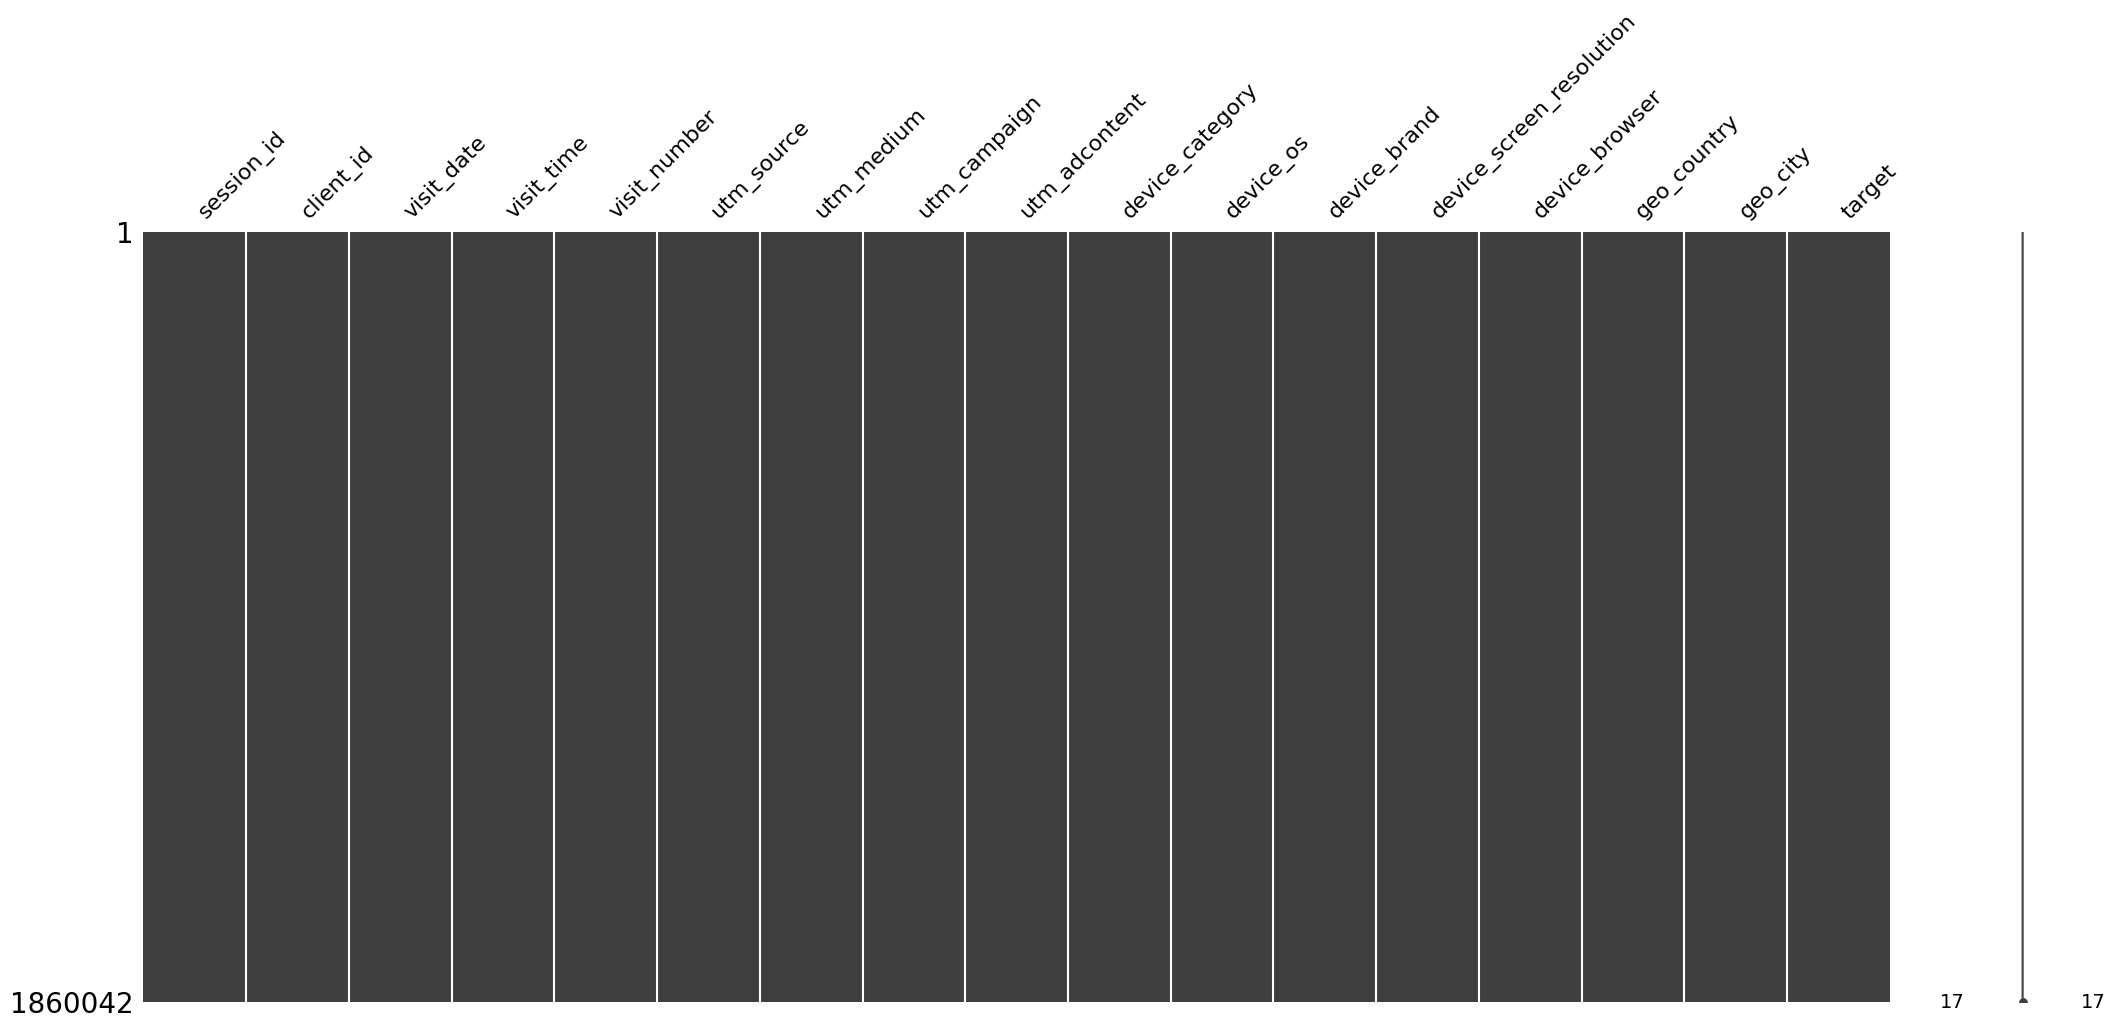

In [85]:
msno.matrix(df_clean);

In [86]:
print_usefull_rows_info_full(df_clean)

Количество полностью заполненных объектов в выборке:  1860042
Процент полностью заполненных объектов в выборке:  100.0
Процент пропусков по столбцам: 
session_id                  0.0
device_category             0.0
geo_city                    0.0
geo_country                 0.0
device_browser              0.0
device_screen_resolution    0.0
device_brand                0.0
device_os                   0.0
utm_adcontent               0.0
client_id                   0.0
utm_campaign                0.0
utm_medium                  0.0
utm_source                  0.0
visit_number                0.0
visit_time                  0.0
visit_date                  0.0
target                      0.0
dtype: float64


### Преобразование типов данных

#### Общий анализ типов данных

In [87]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 17 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              int64  
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   device_category           object 
 10  device_os                 object 
 11  device_brand              object 
 12  device_screen_resolution  object 
 13  device_browser            object 
 14  geo_country               object 
 15  geo_city                  object 
 16  target                    float64
dtypes: float64(1), int64(1), object(15)
memory usage: 241.2+ MB


In [88]:
df_types = df_clean.copy()

In [89]:
df_types.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0.0


#### Преобразование типа данных в дате посещения

In [90]:
# Объединяю столбцы с датой и временем посещения
df_types['visit_date_time'] = df_types['visit_date'] + ' ' +  df_types['visit_time']
df_types.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_date_time
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0.0,2021-11-24 14:36:32
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0.0,2021-11-14 08:21:30
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0.0,2021-12-28 02:42:06
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0.0,2021-05-29 05:00:00
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0.0,2021-05-29 05:00:00


In [91]:
df_types[['visit_date', 'visit_time', 'visit_date_time']]

,visit_date,visit_time,visit_date_time
0,2021-11-24,14:36:32,2021-11-24 14:36:32
1,2021-11-14,08:21:30,2021-11-14 08:21:30
2,2021-12-28,02:42:06,2021-12-28 02:42:06
3,2021-05-29,05:00:00,2021-05-29 05:00:00
4,2021-05-29,05:00:00,2021-05-29 05:00:00
...,...,...,...
1860037,2021-12-22,10:48:25,2021-12-22 10:48:25
1860038,2021-05-26,08:00:00,2021-05-26 08:00:00
1860039,2021-11-15,15:31:55,2021-11-15 15:31:55
1860040,2021-11-29,15:36:44,2021-11-29 15:36:44


In [92]:
df_types[['visit_date', 'visit_time', 'visit_date_time']].dtypes

visit_date         object
visit_time         object
visit_date_time    object
dtype: object

In [93]:
# Преобразуем тип объединенного столбца
df_types['visit_date_time'] = pd.to_datetime(df_types.visit_date_time, utc=True)

In [94]:
df_types[['visit_date', 'visit_time', 'visit_date_time']]

,visit_date,visit_time,visit_date_time
0,2021-11-24,14:36:32,2021-11-24 14:36:32+00:00
1,2021-11-14,08:21:30,2021-11-14 08:21:30+00:00
2,2021-12-28,02:42:06,2021-12-28 02:42:06+00:00
3,2021-05-29,05:00:00,2021-05-29 05:00:00+00:00
4,2021-05-29,05:00:00,2021-05-29 05:00:00+00:00
...,...,...,...
1860037,2021-12-22,10:48:25,2021-12-22 10:48:25+00:00
1860038,2021-05-26,08:00:00,2021-05-26 08:00:00+00:00
1860039,2021-11-15,15:31:55,2021-11-15 15:31:55+00:00
1860040,2021-11-29,15:36:44,2021-11-29 15:36:44+00:00


In [95]:
# Проверяю присовенный тип нового столбца
df_types[['visit_date', 'visit_time', 'visit_date_time']].dtypes

visit_date                      object
visit_time                      object
visit_date_time    datetime64[ns, UTC]
dtype: object

In [96]:
# Удаляю исходные столбцы visit_date и visit_time
df_types = df_types.drop(['visit_date', 'visit_time'], axis=1)

In [97]:
df_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 16 columns):
 #   Column                    Dtype              
---  ------                    -----              
 0   session_id                object             
 1   client_id                 object             
 2   visit_number              int64              
 3   utm_source                object             
 4   utm_medium                object             
 5   utm_campaign              object             
 6   utm_adcontent             object             
 7   device_category           object             
 8   device_os                 object             
 9   device_brand              object             
 10  device_screen_resolution  object             
 11  device_browser            object             
 12  geo_country               object             
 13  geo_city                  object             
 14  target                    float64            
 15  visit_date_time

#### Преобразование категориальных типов данных

In [98]:
category_columns = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category', 'device_os', 'device_brand', 'device_browser']
df_types[category_columns] = df_types[category_columns].astype('category')

In [99]:
df_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 16 columns):
 #   Column                    Dtype              
---  ------                    -----              
 0   session_id                object             
 1   client_id                 object             
 2   visit_number              int64              
 3   utm_source                category           
 4   utm_medium                category           
 5   utm_campaign              category           
 6   utm_adcontent             category           
 7   device_category           category           
 8   device_os                 category           
 9   device_brand              category           
 10  device_screen_resolution  object             
 11  device_browser            category           
 12  geo_country               object             
 13  geo_city                  object             
 14  target                    float64            
 15  visit_date_time

### Выявление аномальных значений

#### Выявление аномалий в столбце номера визита

In [100]:
df_out = df_types.copy()

In [101]:
df_out.visit_number.describe().apply(lambda x: f"{x: 0.3f}")

count     1860042.000
mean            2.713
std            11.829
min             1.000
25%             1.000
50%             1.000
75%             2.000
max           564.000
Name: visit_number, dtype: object

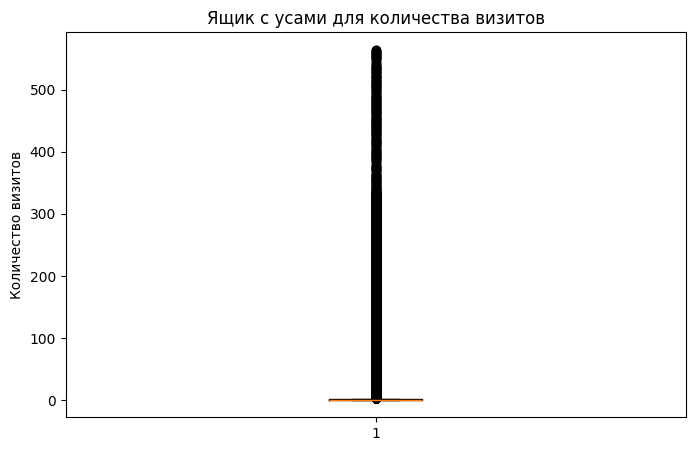

In [102]:
plt.figure(figsize = (8,5))
plt.boxplot(df_out.visit_number)
plt.ylabel('Количество визитов')
plt.title('Ящик с усами для количества визитов');

In [103]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [104]:
calculate_outliers(df_out.visit_number)

(-0.5, 3.5)

In [105]:
boundaries = calculate_outliers(df_out.visit_number)
is_outlier = (df_out.visit_number < boundaries[0]) | (df_out.visit_number > boundaries[1])
is_outlier.sum()

166969

In [106]:
print(f'Доля выбросов в столбце номера визитов: {is_outlier.sum() / len(df_out.visit_number)}')

Доля выбросов в столбце номера визитов: 0.08976625258999528


In [107]:
df_out.loc[is_outlier, 'visit_number'] = int(boundaries[1])

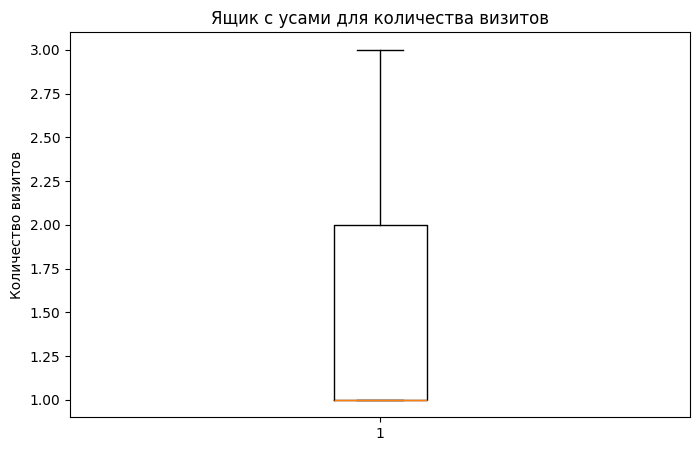

In [108]:
plt.figure(figsize = (8,5))
plt.boxplot(df_out.visit_number)
plt.ylabel('Количество визитов')
plt.title('Ящик с усами для количества визитов');

## Feature Engineering

### Работа со столбцом utm_source

#### Создание новых признаков из столбца utm_source

In [109]:
df_fe = df_out.copy()

In [110]:
df_fe.columns

Index(['session_id', 'client_id', 'visit_number', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'device_category', 'device_os',
       'device_brand', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'target', 'visit_date_time'],
      dtype='object')

In [111]:
#Создадим признак по типу канала привлечения: из социальных сетей и не из социальных сетей
social_net_source_list = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 
                          'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']

In [112]:
df_fe['utm_source_type'] = df_fe.apply(lambda x: 'social_net' if x['utm_source'] in social_net_source_list else 'other', axis=1)

In [113]:
df_fe.utm_source_type.unique()

array(['other', 'social_net'], dtype=object)

#### Перерасчет значений в столбце utm_source

In [114]:
df_fe.utm_source.nunique()

293

В столбце utm_source имеется 293 уникальных значения. Я бы хотел уменьшить их количество во избежании высокой нагрузки на компьютер при моделировании

In [115]:
#Рассмотрю распределение уникальных значений в столбце utm_source в процентах
utm_source_prop = df_fe.utm_source.value_counts(normalize=True).apply(lambda x: 100 * float(f"{x: 0.4f}"))
utm_source_prop.head(20)

utm_source
ZpYIoDJMcFzVoPFsHGJL    31.10
fDLlAcSmythWSCVMvqvL    16.16
kjsLglQLzykiRbcDiGcD    14.32
MvfHsxITijuriZxsqZqt    10.01
BHcvLfOaCWvWTykYqHVe     6.25
bByPQxmDaMXgpHeypKSM     5.50
QxAxdyPLuQMEcrdZWdWb     2.76
aXQzDWsJuGXeBXexNHjc     1.67
jaSOmLICuBzCFqHfBdRg     1.57
RmEBuqrriAfAVsLQQmhk     1.51
vFcAhRxLfOWKhvxjELkx     1.31
PlbkrSYoHuZBWfYjYnfw     1.12
hTjLvqNxGggkGnxSCaTm     0.78
gDBGzjFKYabGgSPZvrDH     0.73
fgymSoTvjKPEgaIJqsiH     0.52
geDcueAOghDzHkGMmdOq     0.47
ISrKoXQCxqqYvAZICvjs     0.46
nSReTmyFtbSjlPrTKoaX     0.39
SzZERoLMmrEUEhDaYcyN     0.37
eLzNJHzPelJpEyBwMrKo     0.29
Name: proportion, dtype: float64

In [116]:
utm_source_prop[utm_source_prop > 0.05].sum()

99.19999999999999

In [117]:
utm_source_prop[utm_source_prop > 0.05].count()

38

Таким образом, имеется 27 значений utm_source, каждый из которых встречается чаще 0.1% и в сумме занимают 98.38% от общего количества объектов. Во избежании повышенной нагрузки на компьютер при моделировании считаю допустимым присвоить значение other всем значениям, встречающимся реже 0.1%

In [118]:
#Значения, встречающиеся чаще 0.1% занимают в сумме более 95% от общего количества объектов. 
#В целях снижения нагрузки на компьютер присвою значениям, встречающимся реже 0.1%, значение other.
utm_source_prop_list = utm_source_prop[utm_source_prop > 0.05].keys().tolist()
utm_source_prop_list

['ZpYIoDJMcFzVoPFsHGJL',
 'fDLlAcSmythWSCVMvqvL',
 'kjsLglQLzykiRbcDiGcD',
 'MvfHsxITijuriZxsqZqt',
 'BHcvLfOaCWvWTykYqHVe',
 'bByPQxmDaMXgpHeypKSM',
 'QxAxdyPLuQMEcrdZWdWb',
 'aXQzDWsJuGXeBXexNHjc',
 'jaSOmLICuBzCFqHfBdRg',
 'RmEBuqrriAfAVsLQQmhk',
 'vFcAhRxLfOWKhvxjELkx',
 'PlbkrSYoHuZBWfYjYnfw',
 'hTjLvqNxGggkGnxSCaTm',
 'gDBGzjFKYabGgSPZvrDH',
 'fgymSoTvjKPEgaIJqsiH',
 'geDcueAOghDzHkGMmdOq',
 'ISrKoXQCxqqYvAZICvjs',
 'nSReTmyFtbSjlPrTKoaX',
 'SzZERoLMmrEUEhDaYcyN',
 'eLzNJHzPelJpEyBwMrKo',
 'IZEXUFLARCUMynmHNBGo',
 'iNFgfQPqHPBuvGCYtrQE',
 'oZCzWSykfixnjMPDNjSU',
 'gVRrcxiDQubJiljoTbGm',
 'nmfptFmSirEqNzAzqbXA',
 'GpAkIXsclxDGyILfNlrR',
 'TxKUcPpthBDPieTGmVhx',
 'ghoaGAksqhKomdFrxgyJ',
 'KgicpPxiEQfzPlPwQZJq',
 'nrKihqcWGIzDsOqljdAv',
 'BKeImrJuRDZcHiSSTdzm',
 'DnEUulZAecfGPvdtZBYS',
 'YlsczTIyBSwTLNtuDkCd',
 'YclHumxPxSxgzHfvCaeF',
 'klTrhUaShgnjIbaPmqjc',
 'dyicZQGoeASogoSafjEh',
 'HFaOtpcChAlcMuxEAlpu',
 'TTtiRKFZIaQpIWggfCoF']

In [119]:
df_fe['utm_source'] = df_fe['utm_source'].apply(lambda x: x if x in utm_source_prop_list else 'other')

In [120]:
print(f'После переименования в стобце utm_source стало {df_fe.utm_source.nunique()} значений')

После переименования в стобце utm_source стало 39 значений


### Работа со столбцом utm_medium

#### Создание новых признаков из столбца utm_medium

In [121]:
#Создадим признак по типу трафика: органический и неорганический
organic_medium_list = ['organic', 'referral', '(none)']

In [122]:
df_fe['utm_medium_type'] = df_fe.apply(lambda x: 'organic' if x['utm_medium'] in organic_medium_list else 'other', axis=1)

In [123]:
df_fe.utm_medium_type.unique()

array(['other', 'organic'], dtype=object)

In [124]:
df_fe.columns.tolist()

['session_id',
 'client_id',
 'visit_number',
 'utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'device_category',
 'device_os',
 'device_brand',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city',
 'target',
 'visit_date_time',
 'utm_source_type',
 'utm_medium_type']

#### Перерасчет значений в столбце utm_medium

In [125]:
df_fe.utm_medium.nunique()

56

В столбце utm_source имеется 56 уникальных значений. Перерасчитывать не считаю необходимым

### Работа со столбцом utm_campaign

#### Создание новых признаков из столбца utm_campaign

У нас нет дополнительной информации по столбцу utm_campaign, поэтому создание новых признаков невозможно

#### Перерасчет значений в столбце utm_campaign

In [126]:
df_fe.utm_campaign.nunique()

413

В столбце utm_campaign имеется 416 уникальных значения. Я бы хотел уменьшить их количество во избежании высокой нагрузки на компьютер при моделировании

In [127]:
#Рассмотрю распределение уникальных значений в столбце utm_campaign в процентах
utm_campaign_prop = df_fe.utm_campaign.value_counts(normalize=True).apply(lambda x: 100 * float(f"{x: 0.4f}"))
utm_campaign_prop.head(20)

utm_campaign
LTuZkdKfxRGVceoWkVyg    24.92
LEoPHuyFvzoNfnzGgfcd    17.42
FTjNLDyTrXaWYgZymFkV    13.30
other                   11.81
gecBYcKZCPMcVYdSSzKP     7.21
TmThBvoCcwkCZZUWACYq     1.43
XHNUiSKKGTEpSAlaVMFQ     1.32
okTXSMadDkjvntEHzIjp     1.32
SgIUDYUKnyWHVowUOqid     1.23
sbJRYgVfvcnqKJNDDYIr     1.09
LwJZxKuWmvOhPsaCeRjG     0.95
RoDitORHdzGfGhNCyEMy     0.84
bxOTvPtyGSdUrbwoXCPO     0.83
zxoiLxhuSIFrCeTLQVWZ     0.67
bJJuEXRheRIxXEaYIXqM     0.66
YCKgTzTDywjcWyQudGch     0.65
nSReTmyFtbSjlPrTKoaX     0.62
QEejXfOCtOMFLZqIPApp     0.55
vRLTQQKAsFQMxbcHGPhu     0.51
jvsVVQVKRfBIqBDBuCkq     0.43
Name: proportion, dtype: float64

In [128]:
utm_campaign_prop[utm_campaign_prop > 0.05].sum()

97.37

In [129]:
utm_campaign_prop[utm_campaign_prop > 0.05].count()

76

Таким образом, имеется значения utm_campaign, каждый из которых встречается более 0.1% и в сумме занимают 95.69% от общего количества объектов. Во избежании повышенной нагрузки на компьютер при моделировании считаю допустимым присвоить значение other всем значениям, встречающимся реже 0.1%

In [130]:
utm_campaign_prop_list = utm_campaign_prop[utm_campaign_prop > 0.05].keys().tolist()
len(utm_campaign_prop_list)

76

In [131]:
df_fe['utm_campaign'] = df_fe['utm_campaign'].apply(lambda x: x if x in utm_campaign_prop_list else 'other')

In [132]:
df_fe.utm_campaign.nunique()

76

Теперь имеем 53 уникальных значения вместо 413

### Работа со столбцом utm_adcontent

#### Создание новых признаков из столбца utm_adcontent

У нас нет дополнительной информации по столбцу utm_adcontent, поэтому создание новых признаков невозможно

#### Перерасчет значений в столбце utm_adcontent

In [133]:
df_fe.utm_adcontent.nunique()

286

В столбце utm_adcontent имеется 286 уникальных значения. Я бы хотел уменьшить их количество во избежании высокой нагрузки на компьютер при моделировании

In [134]:
#Рассмотрю распределение уникальных значений в столбце utm_adcontent в процентах
utm_adcontent_prop = df_fe.utm_adcontent.value_counts(normalize=True).apply(lambda x: 100 * float(f"{x: 0.4f}"))
utm_adcontent_prop.head(20)

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    72.16
vCIpmpaGBnIQhyYNkXqp     9.73
xhoenQgDQsgfEPYNPwKO     6.08
PkybGvWbaqORmxjNunqZ     3.24
LLfCasrxQzJIyuldcuWy     1.30
TuyPWsGQruPMpKvRxeBF     0.98
UxrnyMlRBSOhOjytXnMG     0.73
dUuXlWzvmhDSyclWRhNP     0.55
yYdBRbPmBMUZHXwqGxNx     0.52
WYLajZgbUhGimwBKDZUH     0.46
SOkCdPxfUcZUzzOdgGES     0.39
AdeErYgVTbRcAWtHrMHq     0.34
nNqUcgFgcqQbTVSvgaHr     0.33
aYAcKhelKzYpXrRYknSP     0.27
XSkXBCPfnJjvxbfeewtd     0.24
XKsYZiUFcdkUXQpoLKyS     0.22
FkiRXDLOWtzVfvhEkhNo     0.15
xnyHaukLtAvgViiZSyBC     0.14
SAVVWaMghGnnvPOqMOIt     0.13
guyNoEvzgofQvvwExGOq     0.12
Name: proportion, dtype: float64

In [135]:
utm_adcontent_prop[utm_adcontent_prop > 0.05].sum()

98.72

In [136]:
utm_adcontent_prop[utm_adcontent_prop > 0.05].count()

28

Таким образом, имеется 21 значение utm_adcontent, каждый из которых встречается более 0.1% и в сумме занимают 98.19% от общего количества объектов. Во избежании повышенной нагрузки на компьютер при моделировании считаю допустимым присвоить значение other всем значениям, встречающимся реже 0.1%

In [137]:
utm_adcontent_prop_list = utm_adcontent_prop[utm_adcontent_prop > 0.05].keys().tolist()
len(utm_adcontent_prop_list)

28

In [138]:
df_fe['utm_adcontent'] = df_fe['utm_adcontent'].apply(lambda x: x if x in utm_adcontent_prop_list else 'other')

In [139]:
df_fe.utm_adcontent.nunique()

29

Теперь имеем 22 уникальных значения вместо 286

### Работа со столбцом device_category

In [140]:
df_fe.device_category.nunique()

3

Дополнительно работать с данным столбцом не требуется

### Работа со столбцом device_os

In [141]:
df_fe.device_os.nunique()

14

Дополнительно работать с данным столбцом не требуется

### Работа со столбцом device_brand

In [142]:
df_fe.device_brand.nunique()

206

In [143]:
#Рассмотрю распределение уникальных значений в столбце device_brand в процентах
device_brand_prop = df_fe.device_brand.value_counts(normalize=True).apply(lambda x: 100 * float(f"{x: 0.4f}"))
device_brand_prop.head(20)

device_brand
Apple        30.96
other        18.41
Samsung      17.86
Xiaomi       15.50
Huawei        9.99
Realme        1.02
(not set)     0.94
OPPO          0.73
Vivo          0.63
OnePlus       0.54
Asus          0.43
Nokia         0.39
Sony          0.35
ZTE           0.34
Google        0.28
Meizu         0.20
Lenovo        0.17
Blackview     0.15
Tecno         0.14
LG            0.13
Name: proportion, dtype: float64

In [144]:
device_brand_prop[device_brand_prop > 0.05].sum()

99.42999999999999

In [145]:
device_brand_prop[device_brand_prop > 0.05].count()

23

Таким образом, имеется 21 значение device_brand, каждый из которых встречается более 0.1% и в сумме занимают 99.29% от общего количества объектов. Во избежании повышенной нагрузки на компьютер при моделировании считаю допустимым присвоить значение other всем значениям, встречающимся реже 0.1%

In [146]:
device_brand_prop_list = device_brand_prop[device_brand_prop > 0.1].keys().tolist()
len(device_brand_prop_list)

21

In [147]:
df_fe['device_brand'] = df_fe['device_brand'].apply(lambda x: x if x in device_brand_prop_list else 'other')

In [148]:
df_fe.device_brand.nunique()

21

Теперь имеем 21 уникальное значение вместо 206

### Работа со столбцом device_screen_resolution

Рассчитаю новый признак - площадь экрана, и заменю им столбец device_screen_resolution

In [149]:
df_fe.device_screen_resolution.value_counts()

device_screen_resolution
414x896      169090
1920x1080    125768
375x812      117944
393x851      115454
375x667       93341
              ...  
2262x1553         1
1097x617          1
421x847           1
1791x1007         1
464x1123          1
Name: count, Length: 5039, dtype: int64

In [150]:
len(df_fe[df_fe['device_screen_resolution'] == '(not set)'])

8

Объектам, для которых не определены размеры экрана, присвою самое популярное значение. Считаю это допустимым, так как таких объектов всего 8.

In [151]:
df_fe['device_screen_resolution'] = df_fe['device_screen_resolution'].apply(lambda x: x if x != '(not set)' else '414x896')

In [152]:
len(df_fe[df_fe['device_screen_resolution'] == '(not set)'])

0

In [153]:
df_fe['device_screen_resolution']

0            360x720
1            385x854
2            360x720
3            393x786
4            393x786
             ...    
1860037    1920x1080
1860038      390x844
1860039      375x667
1860040      393x851
1860041     1366x768
Name: device_screen_resolution, Length: 1860042, dtype: object

Создадим 2 признака, описывающие длину и ширину экрана

In [154]:
df_fe['device_screen_a'] = df_fe['device_screen_resolution'].apply(lambda x: x.lower().split('x')).apply(lambda x: int(x[0]))
df_fe['device_screen_b'] = df_fe['device_screen_resolution'].apply(lambda x: x.lower().split('x')).apply(lambda x: int(x[1]))

Проверим значения длины и высоты экрана на аномальные значения

Так как размеры экрана могут сильно отличаться для разных типов устройств, имеет смысл проверить для каждой группы.

#### Проверка на аномальные значения размеров экрана для мобильных устройств

##### Исследование разрешения по высоте для мобильных устройств

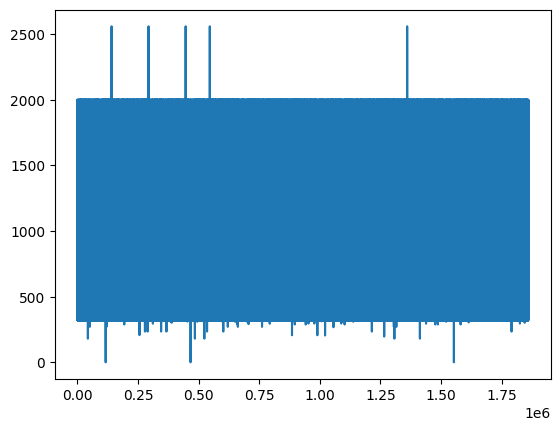

In [155]:
plt.plot(df_fe[df_fe['device_category'] == 'mobile'].device_screen_a);

In [156]:
a_mobile_min = df_fe[df_fe["device_category"] == 'mobile'].device_screen_a.min()
a_mobile_max = df_fe[df_fe["device_category"] == 'mobile'].device_screen_a.max()

print(f'Минимальное разрешение по высоте для мобильных устройств: {a_mobile_min}')
print(f'Минимальное разрешение по высоте для мобильных устройств: {a_mobile_max}')

Минимальное разрешение по высоте для мобильных устройств: 0
Минимальное разрешение по высоте для мобильных устройств: 2560


Что касается максимального значения разрешения по высоте, это значение возможно для мобильный устройств. А вот минимальное значение требует коррекции. Присвоим объектам с нулевым значением граничное минимальное с учетом распределения.

In [157]:
df_fe[(df_fe["device_category"] == 'mobile') & (df_fe['device_screen_a'] == 0)]

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_date_time,utm_source_type,utm_medium_type,device_screen_a,device_screen_b
116630,1275445726215482012.1633495707.1633495707,296962849.1633495708,1,BHcvLfOaCWvWTykYqHVe,cpc,other,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,0x0,YaBrowser,Russia,Vladivostok,0.0,2021-10-06 07:00:00+00:00,other,other,0,0
466768,2840248306670648388.1627536509.1627536509,661296841.1627536452,1,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,mobile,Android,Samsung,0x0,YaBrowser,Russia,Moscow,0.0,2021-07-29 08:00:00+00:00,other,other,0,0
1553066,7684970892572382028.1627280225.1627280225,1789296719.1627280204,1,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,mobile,Android,Samsung,0x0,Chrome,Russia,Saint Petersburg,0.0,2021-07-26 09:00:00+00:00,other,other,0,0


In [158]:
df_fe[df_fe["device_category"] == 'mobile'].device_screen_a.mode()

0    360
Name: device_screen_a, dtype: int64

Так как мы имеем дело не с аномальным значением, а с явным браком, заполним нулевые значения самым часто встречающимся значением

In [159]:
df_fe['device_screen_a'] = df_fe.apply(lambda x: 360 if ((x.device_category == 'mobile') and (x.device_screen_a == 0)) else x.device_screen_a, axis=1)

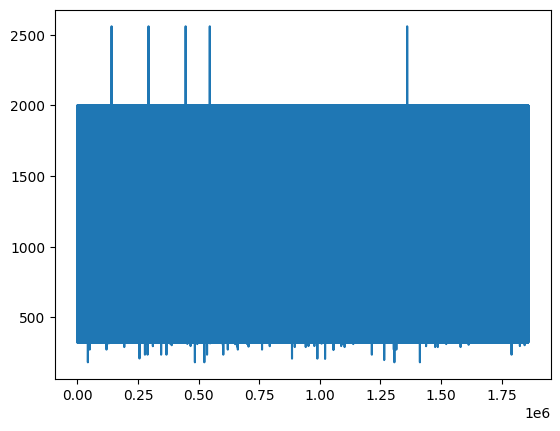

In [160]:
plt.plot(df_fe[df_fe['device_category'] == 'mobile'].device_screen_a);

Теперь нулевых значений нет

##### Исследование разрешения по ширине для мобильных устройств

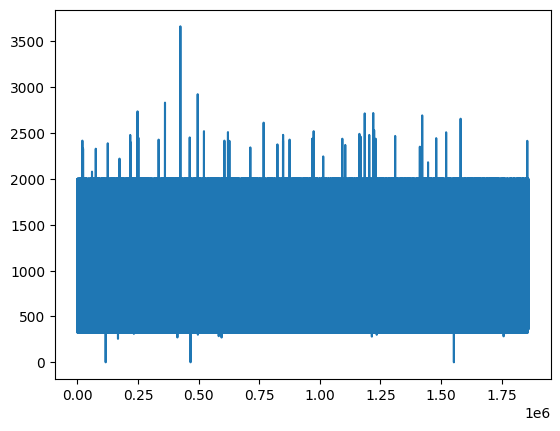

In [161]:
plt.plot(df_fe[df_fe['device_category'] == 'mobile'].device_screen_b);

In [162]:
b_mobile_min = df_fe[df_fe["device_category"] == 'mobile'].device_screen_b.min()
b_mobile_max = df_fe[df_fe["device_category"] == 'mobile'].device_screen_b.max()

print(f'Минимальное разрешение по высоте для мобильных устройств: {b_mobile_min}')
print(f'Минимальное разрешение по высоте для мобильных устройств: {b_mobile_max}')

Минимальное разрешение по высоте для мобильных устройств: 0
Минимальное разрешение по высоте для мобильных устройств: 3662


In [163]:
df_fe[(df_fe["device_category"] == 'mobile') & (df_fe['device_screen_b'] == 3662)]

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_date_time,utm_source_type,utm_medium_type,device_screen_a,device_screen_b
424784,2653657829080757964.1640691408.1640691408,617852860.1640691404,1,nmfptFmSirEqNzAzqbXA,cpc,FTjNLDyTrXaWYgZymFkV,xnyHaukLtAvgViiZSyBC,mobile,Android,Samsung,1648x3662,Chrome,Russia,Moscow,0.0,2021-12-28 14:36:48+00:00,other,other,1648,3662


Что касается максимального значения, оно выглядит вполне логично, так как и высота этого устройства также велика. Разбираемся с объектами, у которых значение по высоте равно 0.

In [164]:
df_fe[(df_fe["device_category"] == 'mobile') & (df_fe['device_screen_b'] == 0)]

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_date_time,utm_source_type,utm_medium_type,device_screen_a,device_screen_b
116630,1275445726215482012.1633495707.1633495707,296962849.1633495708,1,BHcvLfOaCWvWTykYqHVe,cpc,other,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,0x0,YaBrowser,Russia,Vladivostok,0.0,2021-10-06 07:00:00+00:00,other,other,360,0
466768,2840248306670648388.1627536509.1627536509,661296841.1627536452,1,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,mobile,Android,Samsung,0x0,YaBrowser,Russia,Moscow,0.0,2021-07-29 08:00:00+00:00,other,other,360,0
1553066,7684970892572382028.1627280225.1627280225,1789296719.1627280204,1,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,mobile,Android,Samsung,0x0,Chrome,Russia,Saint Petersburg,0.0,2021-07-26 09:00:00+00:00,other,other,360,0


Это те же самые объекты, для которых и высота экрана была нулевой. Значит имеем дело с тем же браком, заменяем нули самым часто встречающимся значением

In [165]:
df_fe[df_fe["device_category"] == 'mobile'].device_screen_b.mode()

0    896
Name: device_screen_b, dtype: int64

In [166]:
df_fe['device_screen_b'] = df_fe.apply(lambda x: 896 if ((x.device_category == 'mobile') and (x.device_screen_b == 0)) else x.device_screen_b, axis=1)

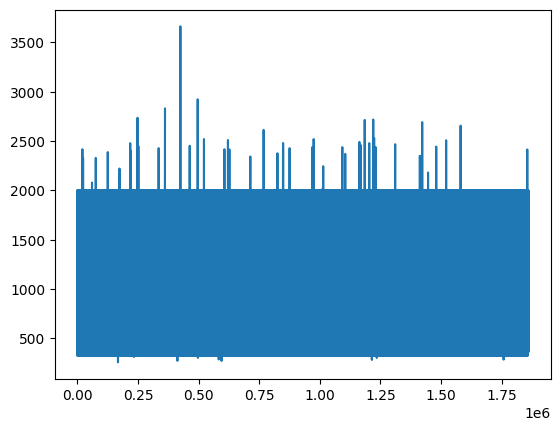

In [167]:
plt.plot(df_fe[df_fe['device_category'] == 'mobile'].device_screen_b);

Теперь нулевых значений нет

#### Проверка на аномальные значения размеров экрана для планшетов

##### Исследование разрешения по высоте для планшетов

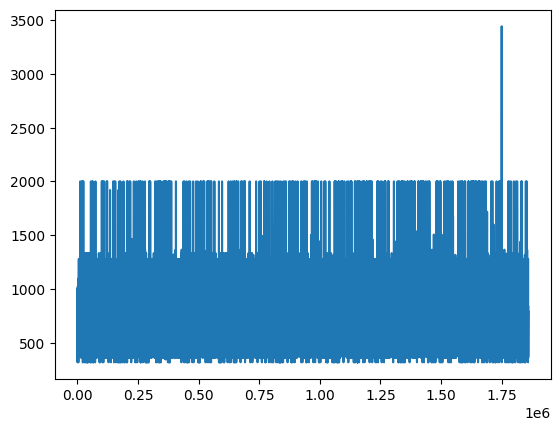

In [168]:
plt.plot(df_fe[df_fe['device_category'] == 'tablet'].device_screen_a);

Судя по графику, есть одно аномально высокое значение.

In [169]:
a_tablet_min = df_fe[df_fe["device_category"] == 'tablet'].device_screen_a.min()
a_tablet_max = df_fe[df_fe["device_category"] == 'tablet'].device_screen_a.max()

print(f'Минимальное разрешение по высоте для планшетов: {a_tablet_min}')
print(f'Минимальное разрешение по высоте для планшетов: {a_tablet_max}')

Минимальное разрешение по высоте для планшетов: 320
Минимальное разрешение по высоте для планшетов: 3440


In [170]:
df_fe[(df_fe["device_category"] == 'tablet') & (df_fe['device_screen_a'] == 3440)]

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_date_time,utm_source_type,utm_medium_type,device_screen_a,device_screen_b
1749992,8564456783202813596.1627195037.1627195037,1994067985.1627195036,1,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,tablet,Android,Samsung,3440x1440,YaBrowser,Russia,Saint Petersburg,0.0,2021-07-25 09:00:00+00:00,other,other,3440,1440


Само по себе значение 3440 вполне возможное для планшетов. Но обычно ширина больше высоты. Здесь наоборот. Видимо, ширина и высота поменяны местами. Так как на значении площади это не повлияет, оставим это значение.

##### Исследование разрешения по ширине для планшетов

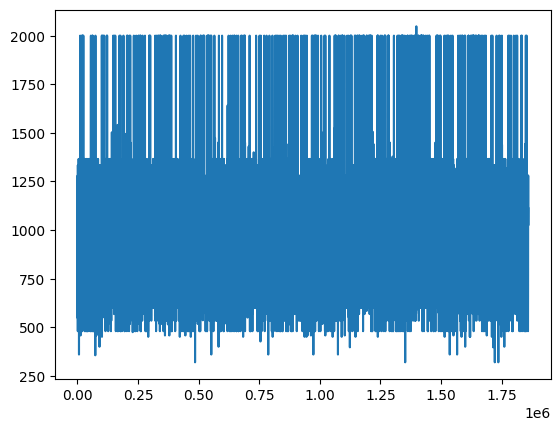

In [171]:
plt.plot(df_fe[df_fe['device_category'] == 'tablet'].device_screen_b);

In [172]:
b_tablet_min = df_fe[df_fe["device_category"] == 'tablet'].device_screen_b.min()
b_tablet_max = df_fe[df_fe["device_category"] == 'tablet'].device_screen_b.max()

print(f'Минимальное разрешение по ширине для планшетов: {b_tablet_min}')
print(f'Минимальное разрешение по ширине для планшетов: {b_tablet_max}')

Минимальное разрешение по ширине для планшетов: 320
Минимальное разрешение по ширине для планшетов: 2048


Значения вполне реальные. Оставляем.

#### Проверка на аномальные значения размеров экрана для компьютеров

##### Исследование разрешения по высоте для компьютеров

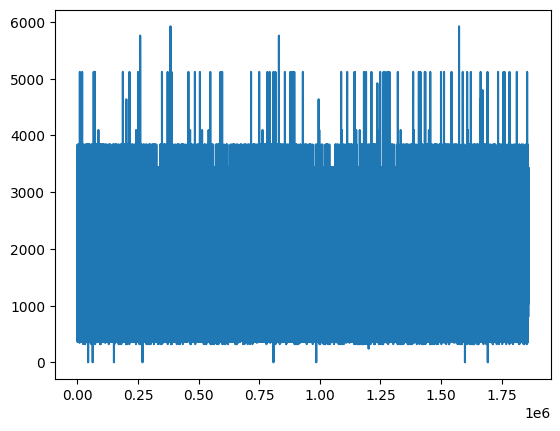

In [173]:
plt.plot(df_fe[df_fe['device_category'] == 'desktop'].device_screen_a);

In [174]:
a_desktop_min = df_fe[df_fe["device_category"] == 'desktop'].device_screen_a.min()
a_desktop_max = df_fe[df_fe["device_category"] == 'desktop'].device_screen_a.max()

print(f'Минимальное разрешение по высоте для планшетов: {a_desktop_min}')
print(f'Минимальное разрешение по высоте для планшетов: {a_desktop_max}')

Минимальное разрешение по высоте для планшетов: 0
Минимальное разрешение по высоте для планшетов: 5924


Максимальные значения выглядят вполне реально. Нулевые значения заменяем самым часто встречающимся

In [175]:
df_fe[(df_fe["device_category"] == 'desktop') & (df_fe['device_screen_a'] == 0)]

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_date_time,utm_source_type,utm_medium_type,device_screen_a,device_screen_b
44288,950433344634896286.1638285216.1638285216,221290007.1638285214,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,0x0,Chrome,Russia,Moscow,0.0,2021-11-30 18:13:36+00:00,other,other,0,0
63108,1034855208904127115.1622241934.1622241934,240946004.1622241931,1,kjsLglQLzykiRbcDiGcD,cpc,other,aYAcKhelKzYpXrRYknSP,desktop,other,other,0x0,Edge,Russia,Saint Petersburg,0.0,2021-05-29 01:00:00+00:00,other,other,0,0
150895,1429325999168992177.1622324145.1622324145,332790892.1622324145,1,kjsLglQLzykiRbcDiGcD,cpc,other,aYAcKhelKzYpXrRYknSP,desktop,other,other,0x0,Chrome,Russia,Moscow,0.0,2021-05-30 00:00:00+00:00,other,other,0,0
268575,1959491500856234812.1626264380.1626264380,456229667.1626264380,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,0x0,Chrome,Russia,Saint Petersburg,0.0,2021-07-14 15:00:00+00:00,other,organic,0,0
808806,4369400154622279642.1640775642.1640775642,1017330250.1640775642,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,desktop,Linux,other,0x0,Chrome,Russia,Saint Petersburg,0.0,2021-12-29 14:00:42+00:00,other,organic,0,0
985350,5153955401013310840.1637528954.1637528954,1199998753.1637528952,1,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,0x0,Chrome,Russia,Moscow,0.0,2021-11-22 00:09:14+00:00,other,other,0,0
1598805,7890126052774737523.1622242931.1622242931,1837063127.1622242931,1,kjsLglQLzykiRbcDiGcD,cpc,other,aYAcKhelKzYpXrRYknSP,desktop,other,other,0x0,Firefox,Russia,Kommunar,0.0,2021-05-29 02:00:00+00:00,other,other,0,0
1692860,8311377506033299631.1632202927.1632202933,1935143374.1632202927,1,bByPQxmDaMXgpHeypKSM,referral,hkvDVxqLOzGjGaoNiNzN,sYzBROYhjSDbFZCpzGyf,desktop,other,other,0x0,Chrome,Russia,Saint Petersburg,0.0,2021-09-21 08:00:00+00:00,other,organic,0,0


In [176]:
df_fe[df_fe["device_category"] == 'desktop'].device_screen_a.mode()

0    1920
Name: device_screen_a, dtype: int64

In [177]:
df_fe['device_screen_a'] = df_fe.apply(lambda x: 1920 if ((x.device_category == 'desktop') and (x.device_screen_a == 0)) else x.device_screen_a, axis=1)

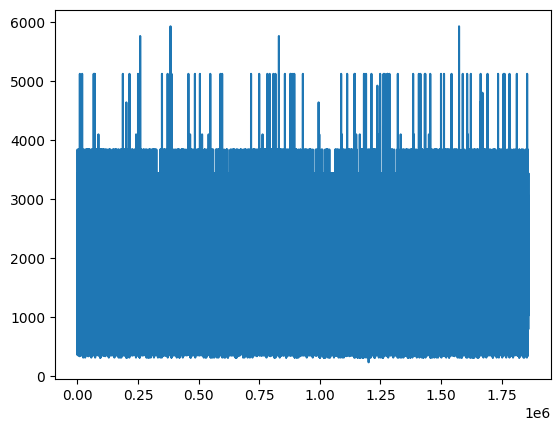

In [178]:
plt.plot(df_fe[df_fe['device_category'] == 'desktop'].device_screen_a);

Теперь нулей нет

##### Исследование разрешения по ширине для компьютеров

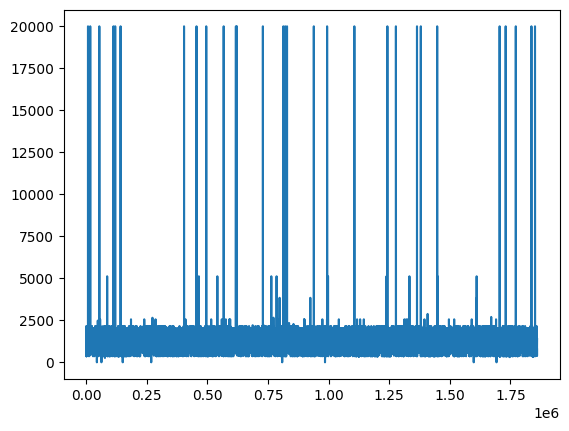

In [179]:
plt.plot(df_fe[df_fe['device_category'] == 'desktop'].device_screen_b);

Есть сразу несколько довольно ощутимых выбросов

In [180]:
b_desktop_min = df_fe[df_fe["device_category"] == 'desktop'].device_screen_b.min()
b_desktop_max = df_fe[df_fe["device_category"] == 'desktop'].device_screen_b.max()

print(f'Минимальное разрешение по ширине для компьютеров: {b_desktop_min}')
print(f'Минимальное разрешение по ширине для компьютеров: {b_desktop_max}')

Минимальное разрешение по ширине для компьютеров: 0
Минимальное разрешение по ширине для компьютеров: 20000


Сначала разбираемся с нулевыми значениями. Заменим самым часто встречающимся значением

In [181]:
df_fe[df_fe["device_category"] == 'desktop'].device_screen_b.mode()

0    1080
Name: device_screen_b, dtype: int64

In [182]:
df_fe['device_screen_b'] = df_fe.apply(lambda x: 1080 if ((x.device_category == 'desktop') and (x.device_screen_b == 0)) else x.device_screen_b, axis=1)

Далее разбираемся с аномально высокими значениями

In [183]:
df_fe[(df_fe["device_category"] == 'desktop') & (df_fe['device_screen_b'] == 20000)]

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_date_time,utm_source_type,utm_medium_type,device_screen_a,device_screen_b
7690,9089787985673454509.1638794162.1638794162,2116381187.1638794157,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0.0,2021-12-06 15:36:02+00:00,other,organic,1600,20000
16893,9130259934944875721.1633604811.1633604811,2125804297.1633604809,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,1600x20000,Chrome,(not set),(not set),0.0,2021-10-07 14:00:00+00:00,other,organic,1600,20000
54385,994460654948701315.1632752773.1632752773,231540914.1632752771,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,1600x20000,Chrome,(not set),(not set),0.0,2021-09-27 17:00:00+00:00,other,organic,1600,20000
112711,1257484293244700670.1635502080.1635502080,292780877.1635502078,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0.0,2021-10-29 13:08:00+00:00,other,organic,1600,20000
119839,1290093398651180319.1638798624.1638798624,300373276.1638798623,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0.0,2021-12-06 16:50:24+00:00,other,organic,1600,20000
142053,1390059170487545779.1638870966.1638870966,323648371.1638870963,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0.0,2021-12-07 12:56:06+00:00,other,organic,1600,20000
403862,2562427329234712068.1640609290.1640609290,596611604.1640609284,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0.0,2021-12-27 15:48:10+00:00,other,organic,1600,20000
455328,2787606391470042918.1630416680.1630416680,649040190.1630416678,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,1600x20000,Chrome,(not set),(not set),0.0,2021-08-31 16:00:00+00:00,other,organic,1600,20000
495461,2970102339313184882.1632743540.1632743540,691530839.1632743538,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,1600x20000,Chrome,(not set),(not set),0.0,2021-09-27 14:00:00+00:00,other,organic,1600,20000
567387,3289030955557742871.1632135449.1632135449,765787194.1632135447,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,1600x20000,Chrome,(not set),(not set),0.0,2021-09-20 13:00:00+00:00,other,organic,1600,20000


Насколько известно, экранов с разрешением 20000 не существует, особенно учитывая, что высота у этих объектов достаточно стандартная. Считаю, что здесь опечатка. Предлагаю заменить значения 20000 на 2000.

In [184]:
df_fe['device_screen_b'] = df_fe.apply(lambda x: 2000 if ((x.device_category == 'desktop') and (x.device_screen_b == 20000)) else x.device_screen_b, axis=1)

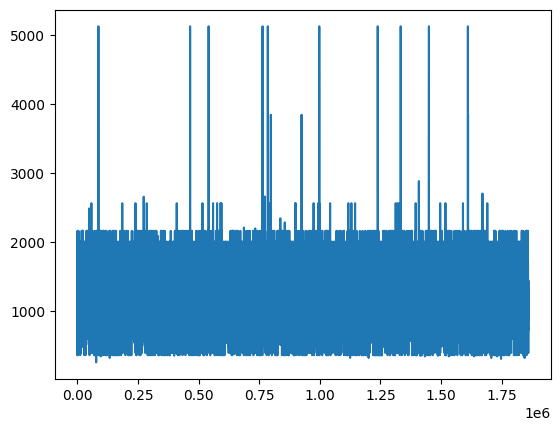

In [185]:
plt.plot(df_fe[df_fe['device_category'] == 'desktop'].device_screen_b);

Значений 0 и 20000 теперь нет. Выступают большие значения около 5000, но такие экраны бывают и считаю, что эти значения трогать не стоит

#### Создание признака площади экрана

In [186]:
df_fe.columns

Index(['session_id', 'client_id', 'visit_number', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'device_category', 'device_os',
       'device_brand', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'target', 'visit_date_time',
       'utm_source_type', 'utm_medium_type', 'device_screen_a',
       'device_screen_b'],
      dtype='object')

In [187]:
df_fe['device_screen_area'] = df_fe.device_screen_a * df_fe.device_screen_b

In [188]:
df_fe.device_screen_area.astype('int64')

0           259200
1           328790
2           259200
3           308898
4           308898
            ...   
1860037    2073600
1860038     329160
1860039     250125
1860040     334443
1860041    1049088
Name: device_screen_area, Length: 1860042, dtype: int64

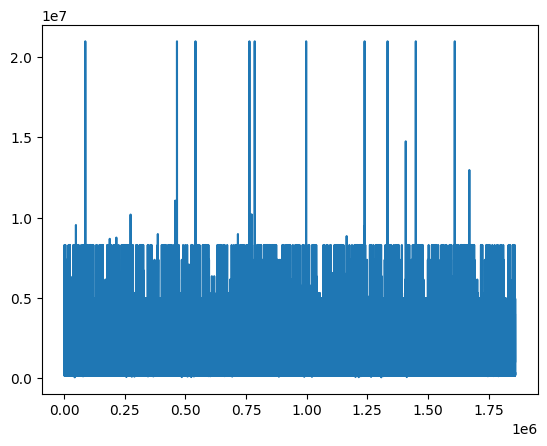

In [189]:
plt.plot(df_fe.device_screen_area);

Проверим значения-выбросы

In [190]:
a_max = df_fe.device_screen_a.max()
b_max = df_fe.device_screen_b.max()
s_max = df_fe.device_screen_area.max()
s_min = df_fe.device_screen_area.min()

print(f'Максимальное разрешение по высоте: {a_max}')
print(f'Максимальное разрешение по ширине: {b_max}')
print(f'Максимальное разрешение по площади: {s_max}')
print(f'Минимальное разрешение по площади: {s_min}')

Максимальное разрешение по высоте: 5924
Максимальное разрешение по ширине: 5120
Максимальное разрешение по площади: 20971520
Минимальное разрешение по площади: 57600


In [191]:
df_fe[df_fe['device_screen_area'] == 20971520]

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,...,device_browser,geo_country,geo_city,target,visit_date_time,utm_source_type,utm_medium_type,device_screen_a,device_screen_b,device_screen_area
86743,114102327610934141.1632338812.1632338812,26566518.1632338813,1,RmEBuqrriAfAVsLQQmhk,cpc,bgTYkDHjOsJzMUtoGhiQ,JNHcPlZPxEMWDnRiyoBf,desktop,Linux,other,...,Chrome,Russia,Mytishchi,0.0,2021-09-22 22:26:52+00:00,other,other,4096,5120,20971520
464941,2832120441845142990.1632458190.1632458190,659404425.1632458190,1,RmEBuqrriAfAVsLQQmhk,cpc,aLJBnHfwxXTnAjVTpHFh,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,...,Chrome,Russia,Mytishchi,0.0,2021-09-24 07:00:00+00:00,other,other,4096,5120,20971520
541289,3173272460128737143.1635833718.1635833718,738835069.1635833719,1,kjsLglQLzykiRbcDiGcD,cpc,UKNBOHebRIIsQRsjNKay,other,desktop,Linux,other,...,Chrome,Russia,Moscow,0.0,2021-11-02 09:15:18+00:00,other,other,4096,5120,20971520
763835,4171094483689653956.1625933510.1625933510,971158613.1625933508,1,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,desktop,other,other,...,Chrome,Russia,Mytishchi,0.0,2021-07-10 19:00:00+00:00,other,other,4096,5120,20971520
785562,426686809008534397.1632400253.1632400253,99345764.1632400253,1,RmEBuqrriAfAVsLQQmhk,cpc,bgTYkDHjOsJzMUtoGhiQ,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,...,Chrome,Russia,Mytishchi,0.0,2021-09-23 15:00:00+00:00,other,other,4096,5120,20971520
997830,5210028548404479196.1632306395.1632306395,1213054300.1632306396,1,RmEBuqrriAfAVsLQQmhk,cpc,iYBYglGljMDRQyqHRiPH,JNHcPlZPxEMWDnRiyoBf,desktop,Linux,other,...,Chrome,Russia,Mytishchi,0.0,2021-09-22 13:26:35+00:00,other,other,4096,5120,20971520
1238901,6289138179581433858.1632393217.1632393217,1464304090.1632393218,1,RmEBuqrriAfAVsLQQmhk,cpc,iYBYglGljMDRQyqHRiPH,JNHcPlZPxEMWDnRiyoBf,desktop,Linux,other,...,Chrome,Russia,Mytishchi,0.0,2021-09-23 13:33:37+00:00,other,other,4096,5120,20971520
1333640,6704821602867820863.1632450878.1632450878,1561087929.1632450879,1,RmEBuqrriAfAVsLQQmhk,cpc,aLJBnHfwxXTnAjVTpHFh,JNHcPlZPxEMWDnRiyoBf,desktop,other,other,...,Chrome,Russia,Mytishchi,0.0,2021-09-24 05:00:00+00:00,other,other,4096,5120,20971520
1450101,7229958333511027993.1640811802.1640811802,1683355852.1640811801,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,Linux,other,...,Chrome,Russia,Moscow,0.0,2021-12-30 00:03:22+00:00,other,other,4096,5120,20971520
1610855,7943637552835608533.1631076308.1631076308,1849522244.1631076309,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,desktop,other,other,...,Chrome,Russia,Mytishchi,0.0,2021-09-08 07:00:00+00:00,other,other,4096,5120,20971520


Действительно, такие значения площади могли быть получены при заданных значения ширины и высоты экрана. Оставляем данные значения

### Работа со столбцом device_browser

In [192]:
df_fe.device_browser.nunique()

57

Дополнительно работать с данным столбцом не требуется

### Работа со столбцом geo_country

In [193]:
df_fe.geo_country.nunique()

166

In [194]:
#Рассмотрю распределение уникальных значений в столбце geo_country в процентах
geo_country_prop = df_fe.geo_country.value_counts(normalize=True).apply(lambda x: 100 * float(f"{x: 0.4f}"))
geo_country_prop.head(20)

geo_country
Russia            96.80
United States      0.63
Ukraine            0.48
Ireland            0.22
Belarus            0.20
Sweden             0.14
Kazakhstan         0.12
Germany            0.12
Turkey             0.10
Netherlands        0.08
Uzbekistan         0.08
United Kingdom     0.08
(not set)          0.06
Kyrgyzstan         0.05
Georgia            0.05
France             0.04
Cyprus             0.04
Armenia            0.04
Finland            0.03
Spain              0.03
Name: proportion, dtype: float64

In [195]:
geo_country_prop[geo_country_prop > 0.05].sum()

99.10999999999999

In [196]:
geo_country_prop[geo_country_prop > 0.05].count()

13

То есть 8 стран, представленных чаще 0.05%, в сумме занимают 99.11% всех данных. Считаю допустимым эти значения оставить, остальным присвоить значение other.

In [197]:
geo_country_prop_list = geo_country_prop[geo_country_prop > 0.05].keys().tolist()
len(geo_country_prop_list)

13

In [198]:
df_fe['geo_country'] = df_fe['geo_country'].apply(lambda x: x if x in geo_country_prop_list else 'other')

In [199]:
df_fe.geo_country.nunique()

14

### Работа со столбцом geo_city

In [200]:
df_fe.geo_city.nunique()

2548

In [201]:
#Рассмотрю распределение уникальных значений в столбце geo_city в процентах
geo_city_prop = df_fe.geo_city.value_counts(normalize=True).apply(lambda x: 100 * float(f"{x: 0.4f}"))
geo_city_prop.head(20)

geo_city
Moscow              43.30
Saint Petersburg    15.96
(not set)            4.20
Yekaterinburg        1.92
Krasnodar            1.73
Kazan                1.59
Samara               1.34
Nizhny Novgorod      1.19
Ufa                  1.17
Novosibirsk          1.16
Krasnoyarsk          0.88
Chelyabinsk          0.86
Tula                 0.85
Voronezh             0.75
Rostov-on-Don        0.75
Irkutsk              0.73
Grozny               0.69
Balashikha           0.68
Vladivostok          0.66
Yaroslavl            0.53
Name: proportion, dtype: float64

In [202]:
geo_city_prop[geo_city_prop > 0.05].sum()

95.23

In [203]:
geo_city_prop[geo_city_prop > 0.05].count()

126

То есть 126 городов, представленных чаще 0.05%, в сумме занимают 95.23% всех данных. Считаю допустимым эти значения оставить, остальным присвоить значение other во избежание увеличения нагрузки на компьютер при моделировании.

In [204]:
geo_city_prop_list = geo_city_prop[geo_city_prop > 0.05].keys().tolist()
len(geo_city_prop_list)

126

In [205]:
df_fe['geo_city'] = df_fe['geo_city'].apply(lambda x: x if x in geo_city_prop_list else 'other')

In [206]:
df_fe.geo_city.nunique()

127

Таким образом уменьшили уникальные значения городов с 2548 до 127

### Работа со столбцом visit_date_time

In [207]:
df_fe.visit_date_time.dtype

datetime64[ns, UTC]

Есть предположение, что в различные месяцы потребность в аренде автомобиля может меняться. Также вероятность сделать целевое действие может быть различной в зависимости от дня недели. В выходные она может быть выше. Если говорить об одном дне, то вероятность совершить ЦД в вечернее время выше, чем в ночное или утреннее. Поэтому имеет смысл создать новые признаки, отвечающие за месяц, день недели и время суток, когда человек заходит на сайт

In [210]:
df_fe['month'] = df_fe.visit_date_time.apply(lambda x: int(x.month))
df_fe['dayofweek'] = df_fe.visit_date_time.apply(lambda x: int(x.dayofweek))
df_fe['timeofday'] = df_fe.visit_date_time.apply(lambda x: int(x.hour))

In [213]:
df_fe.timeofday

0          14
1           8
2           2
3           5
4           5
           ..
1860037    10
1860038     8
1860039    15
1860040    15
1860041    19
Name: timeofday, Length: 1860042, dtype: int64

In [214]:
df_fe.timeofday = df_fe.timeofday.apply(lambda x: 'night' if x in range(0, 6)
                      else 'morning' if x in range(6, 12)
                      else 'day' if x in range(12, 18) 
                      else 'evening')

In [215]:
df_fe.timeofday.value_counts()

timeofday
day        626216
evening    576344
morning    457324
night      200158
Name: count, dtype: int64

### Категоризация новых признаков с помощью OneHotRecorder

In [216]:
df_for_gen = df_fe.copy()

In [217]:
df_for_gen.columns.tolist()

['session_id',
 'client_id',
 'visit_number',
 'utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'device_category',
 'device_os',
 'device_brand',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city',
 'target',
 'visit_date_time',
 'utm_source_type',
 'utm_medium_type',
 'device_screen_a',
 'device_screen_b',
 'device_screen_area',
 'month',
 'dayofweek',
 'timeofday']

In [218]:
df_for_gen.to_csv('data/df_for_gen.csv', index = False)

In [219]:
df_for_gen = pd.read_csv('data/df_for_gen.csv', low_memory=False)

In [220]:
categories = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category', 'device_os', 'device_brand', 
             'device_browser','geo_country', 'geo_city', 'utm_source_type', 'utm_medium_type', 'timeofday']
print('Количество уникальных значений для каждой категории:')
df_for_gen[categories] = df_for_gen[categories].astype('category')
for category in categories: 
    print(category, ':', df_for_gen[category].nunique())

Количество уникальных значений для каждой категории:
utm_source : 39
utm_medium : 56
utm_campaign : 76
utm_adcontent : 29
device_category : 3
device_os : 14
device_brand : 21
device_browser : 57
geo_country : 14
geo_city : 127
utm_source_type : 2
utm_medium_type : 2
timeofday : 4


In [221]:
data_for_ohe = df_for_gen[['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category', 
                              'device_os', 'device_brand', 'device_browser','geo_country', 'geo_city', 
                              'utm_source_type', 'utm_medium_type', 'timeofday']]
data_for_ohe

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,utm_source_type,utm_medium_type,timeofday
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,other,other,other,day
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,social_net,other,morning
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,other,other,night
3,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Android,Xiaomi,Chrome,Russia,Moscow,other,other,night
4,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Moscow,other,other,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,BHcvLfOaCWvWTykYqHVe,cpc,other,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,Chrome,Russia,Moscow,other,other,morning
1860038,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Stavropol,other,organic,morning
1860039,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Moscow,other,organic,day
1860040,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Chelyabinsk,other,other,day


In [222]:
ohe = OneHotEncoder(sparse_output=False)

In [223]:
ohe.fit(data_for_ohe)

OneHotEncoder(sparse_output=False)

In [224]:
ohe_data = ohe.transform(data_for_ohe)
print(ohe_data)
print(ohe_data.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(1860042, 444)


In [225]:
ohe_columns = ohe.get_feature_names_out()

In [226]:
df_ohe = pd.DataFrame(ohe_data, columns=ohe_columns)

In [227]:
df_for_gen_new = pd.concat([df_for_gen, df_ohe], axis=1)

In [228]:
df_for_gen_new.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,...,geo_city_Zhukovskiy,geo_city_other,utm_source_type_other,utm_source_type_social_net,utm_medium_type_organic,utm_medium_type_other,timeofday_day,timeofday_evening,timeofday_morning,timeofday_night
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Android,Xiaomi,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Категориальные признаки закодированы

### Категоризация новых признаков с помощью StandartScaler

In [229]:
std_scaler = StandardScaler()
data_for_std_scaler = df_for_gen_new[['visit_number', 'device_screen_area', 'month', 'dayofweek']]
std_scaler.fit(data_for_std_scaler)
std_scaled = std_scaler.transform(data_for_std_scaler)
std_list = []
for column in data_for_std_scaler.columns:
    std_list.append(column + '_std')
df_for_gen_new[std_list] = std_scaled
df_for_gen_new.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,...,utm_medium_type_organic,utm_medium_type_other,timeofday_day,timeofday_evening,timeofday_morning,timeofday_night,visit_number_std,device_screen_area_std,month_std,dayofweek_std
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,...,0.0,1.0,1.0,0.0,0.0,0.0,-0.553399,-0.498629,0.760687,-0.403088
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,...,0.0,1.0,0.0,0.0,1.0,0.0,-0.553399,-0.399837,0.760687,1.613486
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,...,0.0,1.0,0.0,0.0,0.0,1.0,-0.553399,-0.498629,1.215280,-0.907232
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Android,Xiaomi,...,0.0,1.0,0.0,0.0,0.0,1.0,-0.553399,-0.428077,-1.966869,1.109343
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,other,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,...,0.0,1.0,0.0,0.0,0.0,1.0,0.853329,-0.428077,-1.966869,1.109343


In [6]:
columns_to_drop = ['session_id', 'client_id', 'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 
                   'device_category', 'device_os', 'device_brand', 'device_browser','geo_country', 'geo_city', 
                   'utm_source_type', 'utm_medium_type', 'timeofday', 'visit_number', 'device_screen_area', 'month', 
                   'dayofweek', 'device_screen_resolution', 'visit_date_time', 'device_screen_a', 'device_screen_b']

In [5]:
df_for_gen_new.to_csv('data/df_for_gen_new.csv', index = False)

NameError: name 'df_for_gen_new' is not defined

In [4]:
mylist = []

for chunk in  pd.read_csv('data/df_for_gen_new.csv', chunksize=20000, low_memory=False):
    mylist.append(chunk)
df_prepared = pd.concat(mylist, axis= 0)
del mylist

In [7]:
df_prepared.drop((columns_to_drop), axis = 1, inplace = True)

In [8]:
df_prepared.to_csv('data/df_prepared.csv', index = False)